In [1]:
!pip install torchview
from torchview import draw_graph

In [2]:
import os
import random
import numpy as np
import seaborn as sns
from tqdm import tqdm
from google.colab import drive
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [3]:
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [4]:
#Unziping the data
!unzip -qq "/content/drive/MyDrive/Project Deals/DeepLearning2023/FacialRecognition/Dataset/archive.zip"

In [5]:
#paths:
train_directory="/content/train"
test_directory="/content/test"

In [11]:
label_to_name = {0:'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}

In [6]:
def classification_metric(y_true,y_pred):
  accuracy  = accuracy_score(y_true, y_pred)
  precision = [round(i,2) for i in precision_score(y_true, y_pred,average=None,zero_division=0)]
  recall    = [round(i,2) for i in recall_score(y_true, y_pred,average=None,zero_division=0)]
  f1_value  = [round(i,2) for i in f1_score(y_true, y_pred,average=None,zero_division=0)]
  print("Accuracy is:                 ", round(accuracy,3))
  print("Precision of each class is:  ",*precision)
  print("Recall of each class is:     ",*recall)
  print("F1_score of each class is:   ",*f1_value)


def make_confusion_matrix(y_true,y_pred):
  cm = confusion_matrix(y_true,y_pred)
  plt.figure(figsize = (6,6))
  sns.heatmap(cm, annot=True)
  plt.show()

## Loading Data and Preprocessing

In [7]:
BATCH_SIZE = 32

In [8]:
#Here the data value would be tranformed between 0 and 1
data_transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(30),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    # transforms.RandomPerspective(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#load the data
train_dataset = ImageFolder(train_directory, transform=data_transform_train)
test_dataset = ImageFolder(test_directory, transform=data_transform)

train_size = len(train_dataset)
ts=(train_size*75)//100
vs=train_size-ts
train_dataset, val_dataset = data.random_split(train_dataset, [ts,vs])

print(f"Training data length: {len(train_dataset)}\nTesting data length: {len(test_dataset)}\nValidation data length: {len(val_dataset)}")

Training data length: 21531
Testing data length: 7178
Validation data length: 7178


In [9]:
#Load the data into a dataloder of pytorch
train_dataloader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = data.DataLoader(dataset=val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_dataloader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##Know your data

##1. Number of images belonging to each class of expressions

In [13]:
#Labels in Train data:
data = {}
for _,label in train_dataset:
  v=label
  label_class=label_to_name[v]
  data[label_class]=data.get(label_class,0)+1

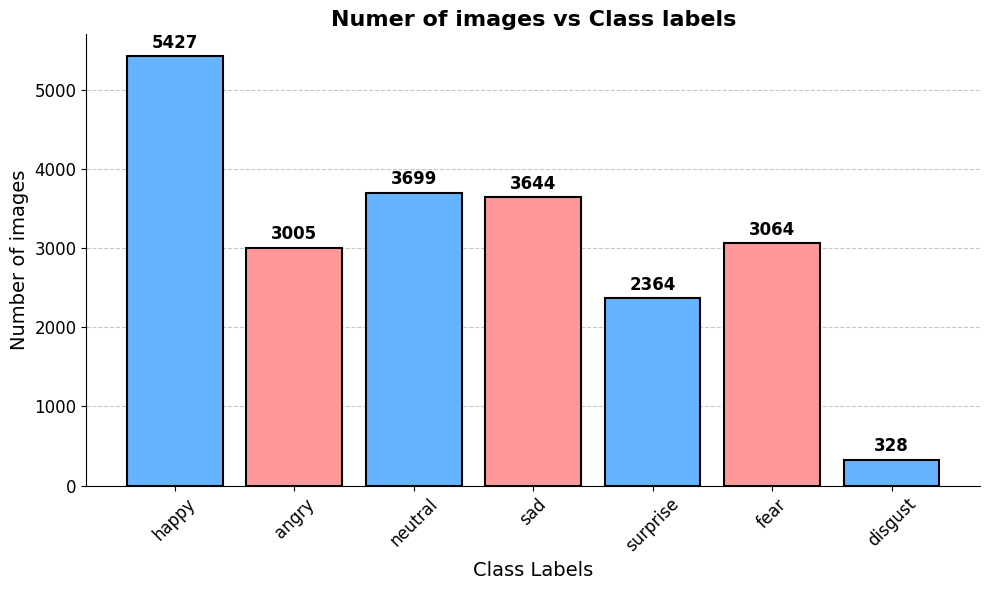

In [16]:
keys = list(data.keys())
values = list(data.values())

# Define a custom color palette
colors = ['#66b3ff', '#ff9999']

# Plotting the data
plt.figure(figsize=(10, 6))
bars = plt.bar(keys, values, color=colors, edgecolor='black', linewidth=1.5)

for bar in bars:
    height = bar.get_height()
    plt.annotate('{}'.format(height),
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xlabel("Class Labels", fontsize=14)
plt.ylabel("Number of images", fontsize=14)
plt.title("Numer of images vs Class labels", fontsize=16, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().set_axisbelow(True)

plt.show()

##2. Sample Train data

In [29]:
def show_images_labels(images, labels):
    # Unnormalize and convert tensors to numpy arrays for visualization
    images = images.numpy().transpose((0, 2, 3, 1))  # Change tensor shape to (batch_size, H, W, C)
    mean = [0.485, 0.456, 0.406] #Mean of Image
    std = [0.229, 0.224, 0.225]  #standard deviation of Image
    images = images * std + mean  # Unnormalize
    images = np.clip(images, 0, 1)
    num_images = len(images)
    num_rows = (num_images + 3) // 6

    fig, axes = plt.subplots(num_rows, 6, figsize=(16, 4 * num_rows))

    for i, ax in enumerate(axes.flat):
        if i < num_images:
            ax.imshow(images[i])
            ax.set_title(f"Label: {label_to_name[labels[i].item()]}")
            ax.axis('off')
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.show()

### Test dataset visualization

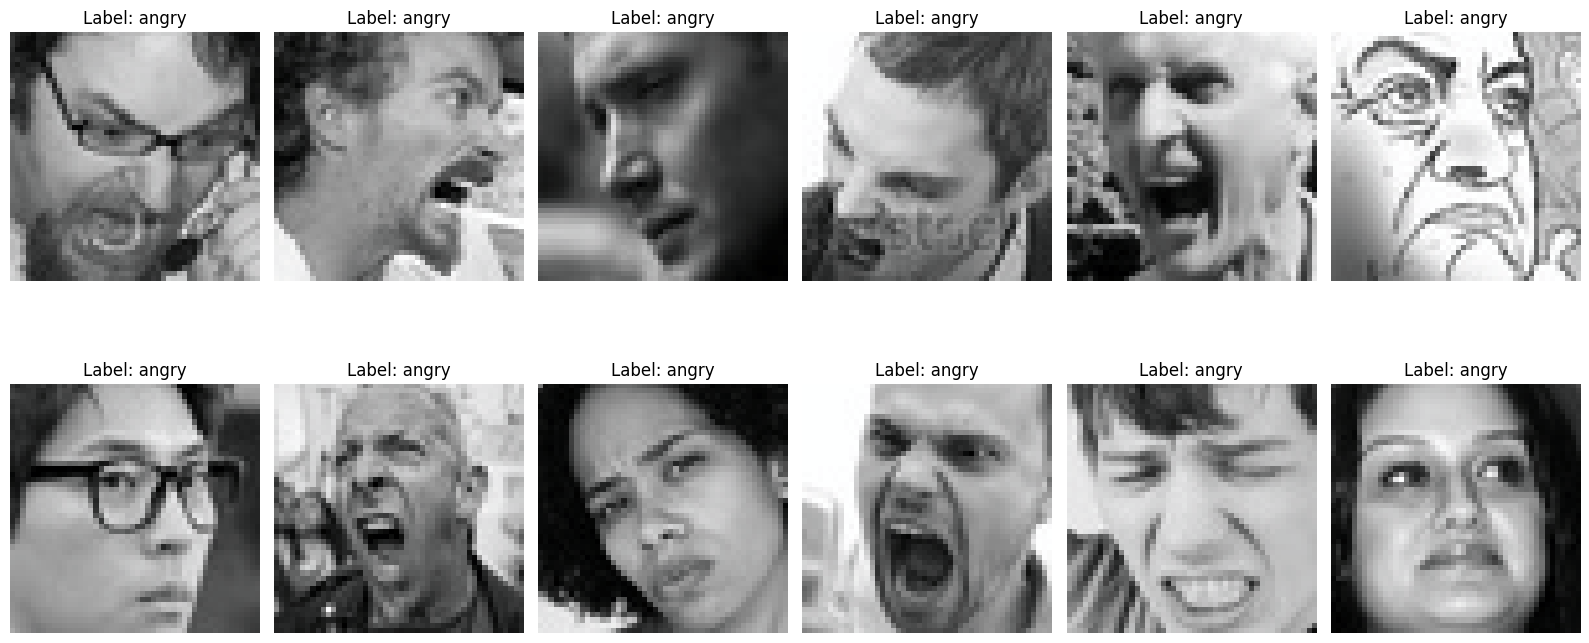

In [33]:
#Test Images without augmentation
for images, labels in test_dataloader:
    show_images_labels(images[:12], labels[:12])
    break

### Augmentation applied on Train dataset

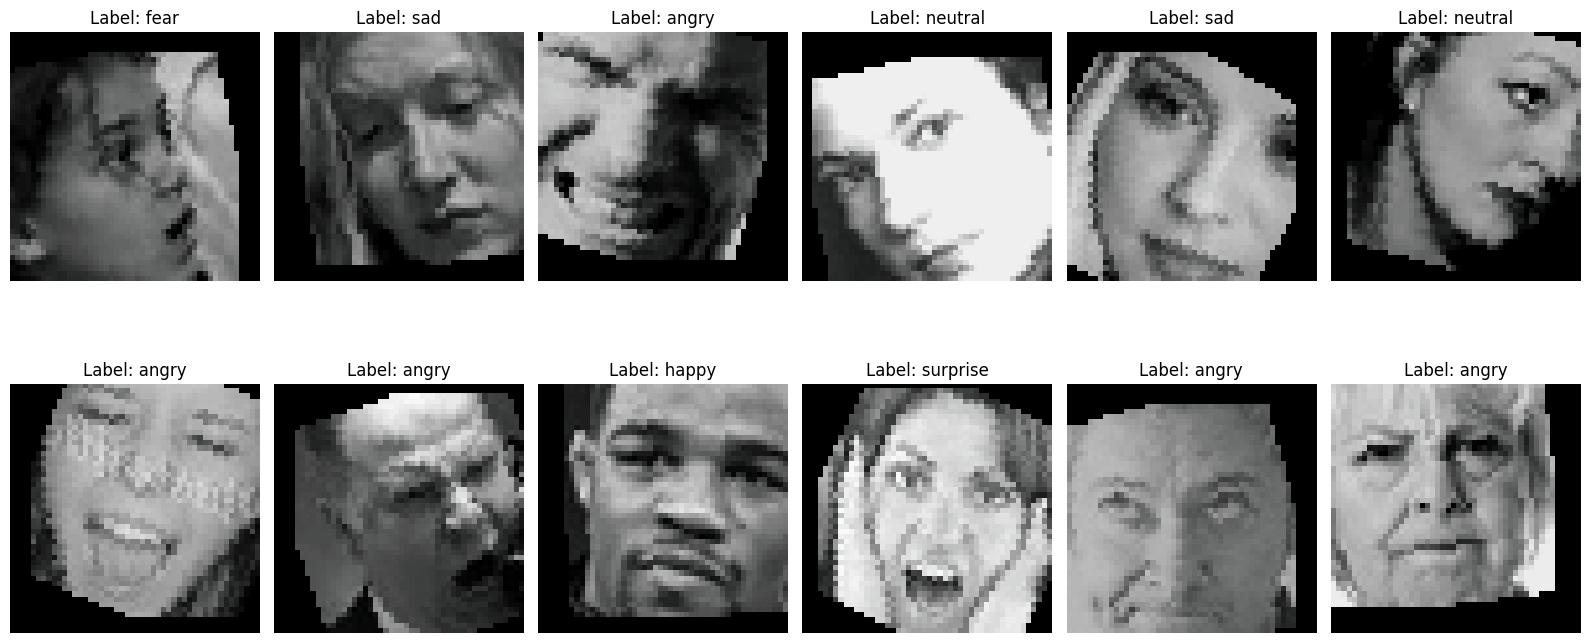

In [35]:
#Train Images with augmentation
for images, labels in train_dataloader:
    show_images_labels(images[:12], labels[:12])
    break

## CNN model

In [36]:
def train_model(num_epochs,model,optimizer,criterion,model_class=None,thresh=10):
  Train_loss=[]
  Train_accuracy=[]
  Val_loss=[]
  Val_accuracy=[]
  threshold=thresh
  stop_threshold=threshold
  l2_regularization=0.00001
  best_loss=10**10
  best_acc=0
  for epoch in tqdm(range(num_epochs)):
      train_loss = 0.0
      val_loss = 0.0
      train_total = 0
      val_total = 0
      train_correct = 0
      val_correct =0

      for i, (images, labels) in enumerate(train_dataloader):
          images = images.to(device)
          labels = labels.to(device)

          # Forward pass
          model.train()
          outputs = model(images)
          loss = criterion(outputs, labels)

          # l2_loss = torch.tensor(0.0)
          # l2_loss = l2_loss.to(device)
          # for param in model.parameters():
          #     l2_loss += torch.norm(param, p=2)
          # loss += l2_regularization * l2_loss

          # Backward
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()

          train_loss += loss.item() * images.size(0)

          # Accuracy
          _, predicted = torch.max(outputs.data, 1)
          train_total += labels.size(0)
          train_correct += (predicted == labels).sum().item()

      # Validation
      model.eval()
      with torch.no_grad():
          for images, labels in val_dataloader:
              images = images.to(device)
              labels = labels.to(device)

              outputs = model(images)
              loss = criterion(outputs, labels)

              val_loss += loss.item() * images.size(0)

              _, predicted = torch.max(outputs.data, 1)
              val_total += labels.size(0)
              val_correct += (predicted == labels).sum().item()

      train_loss = train_loss / len(train_dataloader.dataset)
      val_loss = val_loss / len(val_dataloader.dataset)
      train_accuracy = train_correct / train_total
      val_accuracy = val_correct / val_total

      #Appending value at each epoch
      Train_accuracy.append(train_accuracy)
      Val_accuracy.append(val_accuracy)
      Train_loss.append(train_loss)
      Val_loss.append(val_loss)

      #Early stoppage
      if(val_loss<best_loss or val_accuracy>best_acc):
        best_loss=min(val_loss,best_loss)
        best_acc=max(best_acc,val_accuracy)
        best_model_state=model.state_dict()
        stop_threshold=threshold
      else:
        stop_threshold-=1
      if not stop_threshold:
        break

      print(f"Epoch [{epoch+1}/{num_epochs}] : Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f},  Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")
  if not model_class is None:
    model = model_class()
    model.load_state_dict(best_model_state)
    model.to(device)
  info=[Train_accuracy,Val_accuracy,Train_loss,Val_loss]
  return model,info

In [37]:
#Method to test the model
def test_model(model, criterion, data_loader):
  model.eval()  # Set the model to evaluation mode
  total_correct = 0
  total_samples = 0
  total_loss = 0.0
  y_test=np.array([])
  y_pred=np.array([])
  with torch.no_grad():
      for inputs, labels in data_loader:
          inputs=inputs.to(device)
          labels=labels.to(device)
          outputs = model(inputs)
          _, predicted = torch.max(outputs.data, 1)
          y_test=np.append(y_test,labels.cpu().numpy())
          y_pred=np.append(y_pred,predicted.cpu().numpy())
  classification_metric(y_test,y_pred)
  print("\n"*2)
  print("Confusion Matrix")
  make_confusion_matrix(y_test,y_pred)

In [38]:
#One sample input for diagrams
for sample_input,_ in train_dataloader:
  break
sample_input.shape

torch.Size([32, 3, 48, 48])

##1. Simple CNN model

In [ ]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        # nn.Conv2d()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(1152*4, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(256, 7)

    def forward(self, x):
        out = self.pool1(self.dropout1(self.relu1(self.bn1(self.conv1(x)))))
        out = self.pool2(self.dropout2(self.relu2(self.bn2(self.conv2(out)))))
        out = torch.flatten(out, 1)
        out = self.dropout3(self.relu3(self.bn3(self.fc1(out))))
        out = self.fc2(out)
        out = F.log_softmax(out, dim=-1)
        return out

In [ ]:
#Saving model diagram

save_path="/content/drive/MyDrive/Project Deals/DeepLearning2023/FacialRecognition/model_diagram/cnn_model"
model_graph = draw_graph(CNN_Model(), input_size=(1,3,48,48), expand_nested=True)
model_graph.visual_graph.render(save_path, format="png", view=True)

'/content/drive/MyDrive/Project Deals/DeepLearning2023/FacialRecognition/model_diagram/cnn_model.png'

In [ ]:
# Create a ResNet model
cnn_model = CNN_Model()

# Train your ResNet Model
model = cnn_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs=30

cnn_model,cnn_model_info=train_model(num_epochs,model,optimizer,criterion,CNN_Model)

  3%|▎         | 1/30 [00:43<20:58, 43.38s/it]

Epoch [1/30] : Train Loss: 1.7850, Val Loss: 1.7116,  Train Accuracy: 0.2817, Val Accuracy: 0.3169


  7%|▋         | 2/30 [01:26<20:14, 43.38s/it]

Epoch [2/30] : Train Loss: 1.6794, Val Loss: 1.7012,  Train Accuracy: 0.3262, Val Accuracy: 0.3201


 10%|█         | 3/30 [02:10<19:35, 43.54s/it]

Epoch [3/30] : Train Loss: 1.6377, Val Loss: 1.6172,  Train Accuracy: 0.3567, Val Accuracy: 0.3585


 13%|█▎        | 4/30 [02:53<18:42, 43.19s/it]

Epoch [4/30] : Train Loss: 1.5959, Val Loss: 1.5969,  Train Accuracy: 0.3748, Val Accuracy: 0.3775


 17%|█▋        | 5/30 [03:35<17:52, 42.89s/it]

Epoch [5/30] : Train Loss: 1.5637, Val Loss: 1.5701,  Train Accuracy: 0.3899, Val Accuracy: 0.3792


 20%|██        | 6/30 [04:18<17:13, 43.08s/it]

Epoch [6/30] : Train Loss: 1.5442, Val Loss: 1.5436,  Train Accuracy: 0.4004, Val Accuracy: 0.4090


 23%|██▎       | 7/30 [05:01<16:29, 43.01s/it]

Epoch [7/30] : Train Loss: 1.5254, Val Loss: 1.5238,  Train Accuracy: 0.4090, Val Accuracy: 0.4117


 27%|██▋       | 8/30 [05:43<15:40, 42.74s/it]

Epoch [8/30] : Train Loss: 1.5078, Val Loss: 1.5013,  Train Accuracy: 0.4190, Val Accuracy: 0.4218


 30%|███       | 9/30 [06:27<15:00, 42.86s/it]

Epoch [9/30] : Train Loss: 1.4913, Val Loss: 1.5043,  Train Accuracy: 0.4237, Val Accuracy: 0.4206


 33%|███▎      | 10/30 [07:10<14:20, 43.03s/it]

Epoch [10/30] : Train Loss: 1.4846, Val Loss: 1.4832,  Train Accuracy: 0.4285, Val Accuracy: 0.4324


 37%|███▋      | 11/30 [07:52<13:28, 42.57s/it]

Epoch [11/30] : Train Loss: 1.4750, Val Loss: 1.4823,  Train Accuracy: 0.4340, Val Accuracy: 0.4335


 40%|████      | 12/30 [08:35<12:50, 42.78s/it]

Epoch [12/30] : Train Loss: 1.4636, Val Loss: 1.4688,  Train Accuracy: 0.4349, Val Accuracy: 0.4447


 43%|████▎     | 13/30 [09:19<12:12, 43.07s/it]

Epoch [13/30] : Train Loss: 1.4503, Val Loss: 1.4654,  Train Accuracy: 0.4431, Val Accuracy: 0.4316


 47%|████▋     | 14/30 [10:01<11:23, 42.74s/it]

Epoch [14/30] : Train Loss: 1.4389, Val Loss: 1.4430,  Train Accuracy: 0.4494, Val Accuracy: 0.4508


 50%|█████     | 15/30 [10:44<10:42, 42.82s/it]

Epoch [15/30] : Train Loss: 1.4317, Val Loss: 1.4460,  Train Accuracy: 0.4511, Val Accuracy: 0.4395


 53%|█████▎    | 16/30 [11:27<10:01, 42.94s/it]

Epoch [16/30] : Train Loss: 1.4255, Val Loss: 1.4493,  Train Accuracy: 0.4543, Val Accuracy: 0.4430


 57%|█████▋    | 17/30 [12:09<09:14, 42.69s/it]

Epoch [17/30] : Train Loss: 1.4183, Val Loss: 1.4391,  Train Accuracy: 0.4583, Val Accuracy: 0.4546


 60%|██████    | 18/30 [12:52<08:32, 42.70s/it]

Epoch [18/30] : Train Loss: 1.4048, Val Loss: 1.4227,  Train Accuracy: 0.4643, Val Accuracy: 0.4631


 63%|██████▎   | 19/30 [13:35<07:50, 42.81s/it]

Epoch [19/30] : Train Loss: 1.4058, Val Loss: 1.4172,  Train Accuracy: 0.4586, Val Accuracy: 0.4583


 67%|██████▋   | 20/30 [14:17<07:07, 42.79s/it]

Epoch [20/30] : Train Loss: 1.4016, Val Loss: 1.4089,  Train Accuracy: 0.4655, Val Accuracy: 0.4724


 70%|███████   | 21/30 [14:59<06:23, 42.58s/it]

Epoch [21/30] : Train Loss: 1.3876, Val Loss: 1.4080,  Train Accuracy: 0.4667, Val Accuracy: 0.4575


 73%|███████▎  | 22/30 [15:43<05:42, 42.87s/it]

Epoch [22/30] : Train Loss: 1.3919, Val Loss: 1.4033,  Train Accuracy: 0.4699, Val Accuracy: 0.4675


 77%|███████▋  | 23/30 [16:27<05:01, 43.11s/it]

Epoch [23/30] : Train Loss: 1.3836, Val Loss: 1.3798,  Train Accuracy: 0.4712, Val Accuracy: 0.4735


 80%|████████  | 24/30 [17:08<04:15, 42.66s/it]

Epoch [24/30] : Train Loss: 1.3762, Val Loss: 1.3929,  Train Accuracy: 0.4736, Val Accuracy: 0.4696


 83%|████████▎ | 25/30 [17:52<03:34, 42.87s/it]

Epoch [25/30] : Train Loss: 1.3663, Val Loss: 1.4039,  Train Accuracy: 0.4787, Val Accuracy: 0.4652


 87%|████████▋ | 26/30 [18:35<02:52, 43.08s/it]

Epoch [26/30] : Train Loss: 1.3618, Val Loss: 1.3816,  Train Accuracy: 0.4807, Val Accuracy: 0.4785


 90%|█████████ | 27/30 [19:18<02:08, 42.93s/it]

Epoch [27/30] : Train Loss: 1.3607, Val Loss: 1.3772,  Train Accuracy: 0.4807, Val Accuracy: 0.4702


 93%|█████████▎| 28/30 [20:02<01:26, 43.18s/it]

Epoch [28/30] : Train Loss: 1.3632, Val Loss: 1.3789,  Train Accuracy: 0.4814, Val Accuracy: 0.4774


 97%|█████████▋| 29/30 [20:45<00:43, 43.35s/it]

Epoch [29/30] : Train Loss: 1.3518, Val Loss: 1.3756,  Train Accuracy: 0.4833, Val Accuracy: 0.4727


100%|██████████| 30/30 [21:29<00:00, 42.97s/it]

Epoch [30/30] : Train Loss: 1.3482, Val Loss: 1.3647,  Train Accuracy: 0.4865, Val Accuracy: 0.4868


## Accuracy plot

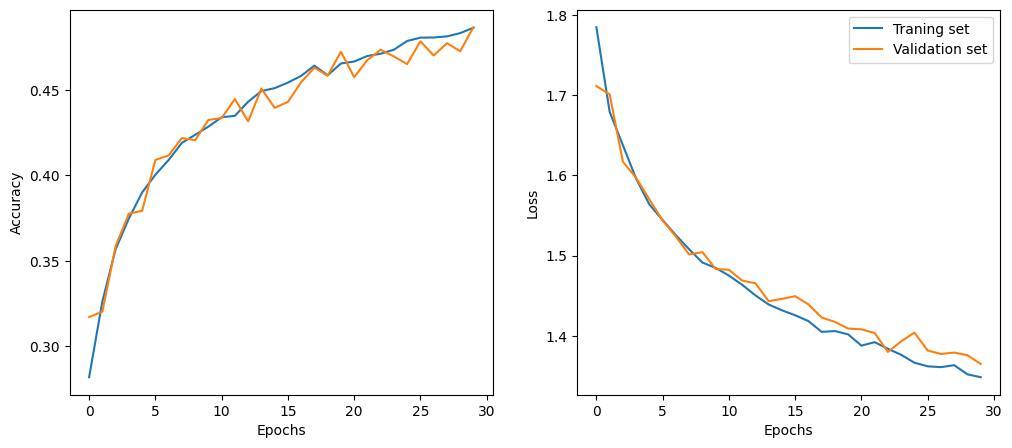

In [ ]:
# Plot loss and accuracy
fig, axs = plt.subplots(1, 2,figsize=(12,5))

x_axis=range(len(cnn_model_info[0]))
axs[0].plot(x_axis,cnn_model_info[0],label="Traning set")
axs[0].plot(x_axis,cnn_model_info[1],label="Validation set")
axs[0].set(ylabel="Accuracy")
axs[0].set(xlabel="Epochs")

axs[1].plot(x_axis,cnn_model_info[2],label="Traning set")
axs[1].plot(x_axis,cnn_model_info[3],label="Validation set")
axs[1].set(ylabel="Loss")
axs[1].set(xlabel="Epochs")

plt.legend()
plt.show()

## Model testing

Accuracy is:                  0.539
Precision of each class is:   0.42 0.63 0.44 0.72 0.52 0.38 0.66
Recall of each class is:      0.41 0.11 0.21 0.8 0.47 0.54 0.68
F1_score of each class is:    0.42 0.18 0.29 0.76 0.49 0.45 0.67



Confusion Matrix


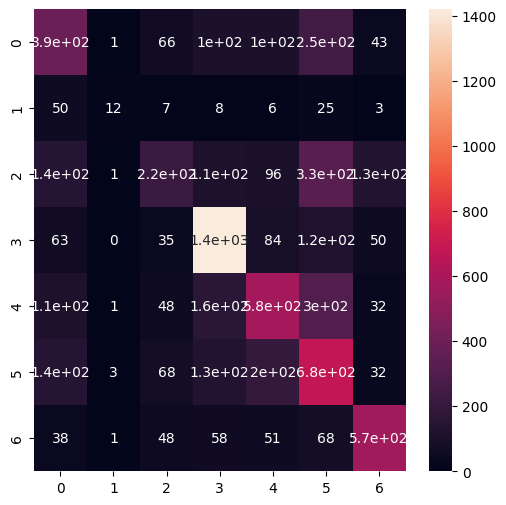

In [ ]:
#Testing the model on test set
test_model(cnn_model,criterion,test_dataloader)

In [ ]:
save_path="/content/drive/MyDrive/Project Deals/DeepLearning2023/FacialRecognition/cnn_model.pth"
torch.save(cnn_model, save_path)

##2. Resnet model

In [ ]:
# Define the basic building blocks of a ResNet: Residual Block and Residual Layer
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 1):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 1)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.avgpool = nn.AvgPool2d(5, stride=1)
        self.fc = nn.Linear(1024, num_classes)
        self.sigmoid = nn.Sigmoid()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.log_softmax(x, dim=-1)
        return x

In [ ]:
#Saving model diagram

save_path="/content/drive/MyDrive/Project Deals/DeepLearning2023/FacialRecognition/model_diagram/resnet_model"
resnet = ResNet(ResidualBlock, [2, 2, 2], num_classes=7)
model_graph = draw_graph(resnet, input_size=(1,3,48,48), expand_nested=True)
model_graph.visual_graph.render(save_path, format="png", view=True)

'/content/drive/MyDrive/Project Deals/DeepLearning2023/FacialRecognition/model_diagram/resnet_model.png'

In [ ]:
# Create a ResNet model
resnet = ResNet(ResidualBlock, [2, 2, 2], num_classes=7)

# Train your ResNet Model
model = resnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs=30

resnet,resnet_info=train_model(num_epochs,model,optimizer,criterion)

  3%|▎         | 1/30 [01:07<32:27, 67.16s/it]

Epoch [1/30] : Train Loss: 1.6744, Val Loss: 1.5977,  Train Accuracy: 0.3290, Val Accuracy: 0.3658


  7%|▋         | 2/30 [01:59<27:19, 58.55s/it]

Epoch [2/30] : Train Loss: 1.4937, Val Loss: 1.4584,  Train Accuracy: 0.4250, Val Accuracy: 0.4409


 10%|█         | 3/30 [02:51<25:00, 55.59s/it]

Epoch [3/30] : Train Loss: 1.4008, Val Loss: 1.4954,  Train Accuracy: 0.4621, Val Accuracy: 0.4207


 13%|█▎        | 4/30 [03:45<23:41, 54.69s/it]

Epoch [4/30] : Train Loss: 1.3457, Val Loss: 1.3954,  Train Accuracy: 0.4849, Val Accuracy: 0.4709


 17%|█▋        | 5/30 [04:37<22:29, 54.00s/it]

Epoch [5/30] : Train Loss: 1.2913, Val Loss: 1.3130,  Train Accuracy: 0.5072, Val Accuracy: 0.4861


 20%|██        | 6/30 [05:30<21:21, 53.41s/it]

Epoch [6/30] : Train Loss: 1.2602, Val Loss: 1.3860,  Train Accuracy: 0.5214, Val Accuracy: 0.4687


 23%|██▎       | 7/30 [06:23<20:30, 53.50s/it]

Epoch [7/30] : Train Loss: 1.2402, Val Loss: 1.2780,  Train Accuracy: 0.5278, Val Accuracy: 0.5134


 27%|██▋       | 8/30 [07:16<19:32, 53.31s/it]

Epoch [8/30] : Train Loss: 1.2095, Val Loss: 1.2398,  Train Accuracy: 0.5402, Val Accuracy: 0.5293


 30%|███       | 9/30 [08:09<18:36, 53.14s/it]

Epoch [9/30] : Train Loss: 1.1917, Val Loss: 1.2294,  Train Accuracy: 0.5495, Val Accuracy: 0.5276


 33%|███▎      | 10/30 [09:03<17:48, 53.44s/it]

Epoch [10/30] : Train Loss: 1.1715, Val Loss: 1.2878,  Train Accuracy: 0.5548, Val Accuracy: 0.5157


 37%|███▋      | 11/30 [09:56<16:51, 53.26s/it]

Epoch [11/30] : Train Loss: 1.1546, Val Loss: 1.2238,  Train Accuracy: 0.5640, Val Accuracy: 0.5419


 40%|████      | 12/30 [10:48<15:54, 53.04s/it]

Epoch [12/30] : Train Loss: 1.1437, Val Loss: 1.2018,  Train Accuracy: 0.5663, Val Accuracy: 0.5410


 43%|████▎     | 13/30 [11:43<15:08, 53.44s/it]

Epoch [13/30] : Train Loss: 1.1270, Val Loss: 1.2127,  Train Accuracy: 0.5692, Val Accuracy: 0.5304


 47%|████▋     | 14/30 [12:35<14:10, 53.14s/it]

Epoch [14/30] : Train Loss: 1.1133, Val Loss: 1.2287,  Train Accuracy: 0.5798, Val Accuracy: 0.5339


 50%|█████     | 15/30 [13:28<13:14, 52.94s/it]

Epoch [15/30] : Train Loss: 1.1034, Val Loss: 1.1867,  Train Accuracy: 0.5866, Val Accuracy: 0.5524


 53%|█████▎    | 16/30 [14:22<12:25, 53.24s/it]

Epoch [16/30] : Train Loss: 1.0882, Val Loss: 1.1717,  Train Accuracy: 0.5903, Val Accuracy: 0.5599


 57%|█████▋    | 17/30 [15:14<11:29, 53.06s/it]

Epoch [17/30] : Train Loss: 1.0716, Val Loss: 1.1336,  Train Accuracy: 0.5935, Val Accuracy: 0.5724


 60%|██████    | 18/30 [16:06<10:33, 52.78s/it]

Epoch [18/30] : Train Loss: 1.0647, Val Loss: 1.1572,  Train Accuracy: 0.5924, Val Accuracy: 0.5600


 63%|██████▎   | 19/30 [17:00<09:43, 53.02s/it]

Epoch [19/30] : Train Loss: 1.0543, Val Loss: 1.1292,  Train Accuracy: 0.6018, Val Accuracy: 0.5740


 67%|██████▋   | 20/30 [17:52<08:48, 52.83s/it]

Epoch [20/30] : Train Loss: 1.0469, Val Loss: 1.1248,  Train Accuracy: 0.6052, Val Accuracy: 0.5823


 70%|███████   | 21/30 [18:45<07:53, 52.64s/it]

Epoch [21/30] : Train Loss: 1.0441, Val Loss: 1.1315,  Train Accuracy: 0.6034, Val Accuracy: 0.5719


 73%|███████▎  | 22/30 [19:38<07:03, 52.93s/it]

Epoch [22/30] : Train Loss: 1.0269, Val Loss: 1.1329,  Train Accuracy: 0.6095, Val Accuracy: 0.5769


 77%|███████▋  | 23/30 [20:31<06:09, 52.77s/it]

Epoch [23/30] : Train Loss: 1.0175, Val Loss: 1.1253,  Train Accuracy: 0.6136, Val Accuracy: 0.5740


 80%|████████  | 24/30 [21:23<05:15, 52.52s/it]

Epoch [24/30] : Train Loss: 1.0048, Val Loss: 1.1160,  Train Accuracy: 0.6205, Val Accuracy: 0.5762


 83%|████████▎ | 25/30 [22:16<04:24, 52.84s/it]

Epoch [25/30] : Train Loss: 1.0007, Val Loss: 1.1547,  Train Accuracy: 0.6222, Val Accuracy: 0.5761


 87%|████████▋ | 26/30 [23:09<03:30, 52.71s/it]

Epoch [26/30] : Train Loss: 0.9903, Val Loss: 1.1113,  Train Accuracy: 0.6290, Val Accuracy: 0.5816


 90%|█████████ | 27/30 [24:01<02:37, 52.51s/it]

Epoch [27/30] : Train Loss: 0.9802, Val Loss: 1.1338,  Train Accuracy: 0.6285, Val Accuracy: 0.5745


 93%|█████████▎| 28/30 [24:54<01:45, 52.72s/it]

Epoch [28/30] : Train Loss: 0.9737, Val Loss: 1.1029,  Train Accuracy: 0.6330, Val Accuracy: 0.5872


 97%|█████████▋| 29/30 [25:47<00:52, 52.76s/it]

Epoch [29/30] : Train Loss: 0.9692, Val Loss: 1.1107,  Train Accuracy: 0.6352, Val Accuracy: 0.5917


100%|██████████| 30/30 [26:39<00:00, 53.33s/it]

Epoch [30/30] : Train Loss: 0.9640, Val Loss: 1.1062,  Train Accuracy: 0.6355, Val Accuracy: 0.5910


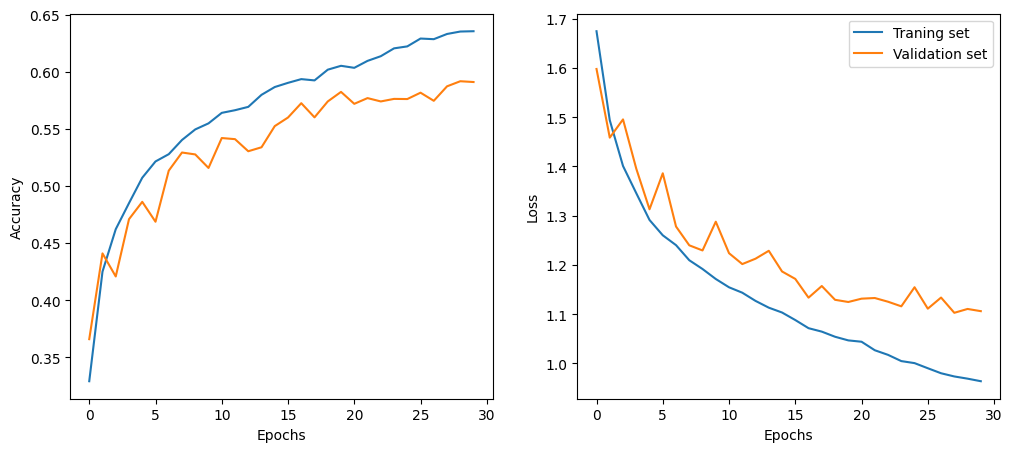

In [ ]:
# Plot loss and accuracy
fig, axs = plt.subplots(1, 2,figsize=(12,5))

x_axis=range(len(resnet_info[0]))
axs[0].plot(x_axis,resnet_info[0],label="Traning set")
axs[0].plot(x_axis,resnet_info[1],label="Validation set")
axs[0].set(ylabel="Accuracy")
axs[0].set(xlabel="Epochs")

axs[1].plot(x_axis,resnet_info[2],label="Traning set")
axs[1].plot(x_axis,resnet_info[3],label="Validation set")
axs[1].set(ylabel="Loss")
axs[1].set(xlabel="Epochs")

plt.legend()
plt.show()

Accuracy is:                  0.609
Precision of each class is:   0.51 0.65 0.55 0.8 0.5 0.47 0.78
Recall of each class is:      0.56 0.31 0.2 0.88 0.68 0.49 0.71
F1_score of each class is:    0.54 0.42 0.29 0.84 0.57 0.48 0.74



Confusion Matrix


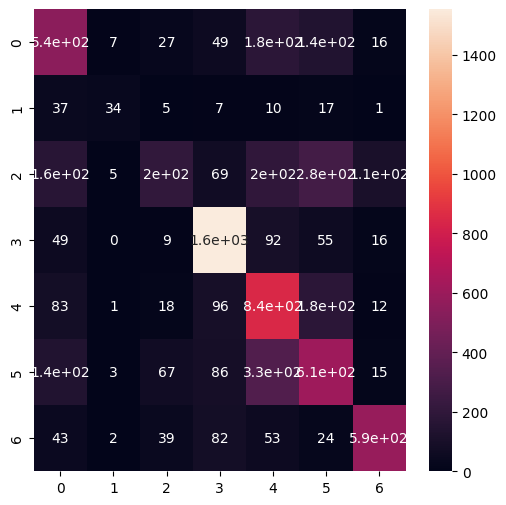

In [ ]:
test_model(resnet,criterion,test_dataloader)

In [ ]:
save_path="/content/drive/MyDrive/Project Deals/DeepLearning2023/FacialRecognition/resnet_model.pth"
torch.save(resnet, save_path)

##3. Google net variation

In [ ]:
import torch.nn.functional as F
class EncoderDecoder(nn.Module):
    def __init__(self):
        super(EncoderDecoder, self).__init__()

        # Encoder
        self.encoder_conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.encoder_conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)

        # Decoder
        self.decoder_deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.decoder_deconv2 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        # Encoder
        x = F.relu(self.encoder_conv1(x))
        x = F.relu(self.encoder_conv2(x))

        # Decoder
        x = F.relu(self.decoder_deconv1(x))
        x = torch.sigmoid(self.decoder_deconv2(x))
        return x

class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class InceptionModule(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, red_7x7, out_7x7):
        super(InceptionModule, self).__init__()

        # 1x1 conv branch
        self.branch1x1 = BasicConv2d(in_channels, out_1x1, kernel_size=1)

        # 3x3 conv branch
        self.branch3x3 = nn.Sequential(
            BasicConv2d(in_channels, red_3x3, kernel_size=1),
            BasicConv2d(red_3x3, out_3x3, kernel_size=3, padding=1)
        )

        # 5x5 conv branch
        self.branch5x5 = nn.Sequential(
            BasicConv2d(in_channels, red_5x5, kernel_size=1),
            BasicConv2d(red_5x5, out_5x5, kernel_size=5, padding=2)
        )

        self.branch7x7 = nn.Sequential(
            BasicConv2d(in_channels, red_7x7, kernel_size=1),
            BasicConv2d(red_7x7, out_7x7, kernel_size=7, padding=3)
        )

    def forward(self, x):
        branch1x1 = self.branch1x1(x)
        branch3x3 = self.branch3x3(x)
        branch5x5 = self.branch5x5(x)
        branch7x7 = self.branch7x7(x)

        outputs = [branch3x3, branch5x5, branch7x7]
        # return torch.sum(torch.stack(outputs), dim=0)
        return torch.cat(outputs, 1)  # Concatenate the outputs along the channel dimension

class GoogleNet(nn.Module):
    def __init__(self, num_classes=7):
        super(GoogleNet, self).__init__()
        self.conv1 = BasicConv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.maxpool1 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        self.enc_dc=EncoderDecoder()

        self.inception1 = InceptionModule(64, 16, 32, 16, 32, 16, 32, 16)
        self.inception2 = InceptionModule(48, 16, 32, 16, 32, 16, 32, 16)

        self.maxpool2 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.1)
        self.conv2 = BasicConv2d(48, 32, kernel_size=3, stride=1, padding=1)

        self.fc = nn.Linear(48, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.inception1(x)
        x = self.dropout1(x)
        x = self.inception2(x)
        # x = self.maxpool2(x)
        x = self.dropout2(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.log_softmax(x, dim=-1)
        return x

In [ ]:
#Saving model diagram

save_path="/content/drive/MyDrive/Project Deals/DeepLearning2023/FacialRecognition/model_diagram/gnet_model"
model_graph = draw_graph(GoogleNet(), input_size=(1,3,48,48), expand_nested=True)
model_graph.visual_graph.render(save_path, format="png", view=True)

'/content/drive/MyDrive/Project Deals/DeepLearning2023/FacialRecognition/model_diagram/gnet_model.png'

In [ ]:
# Create a ResNet model
gnet = GoogleNet()

# Train your ResNet Model
model = gnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs=50

gnet,gnet_info=train_model(num_epochs,model,optimizer,criterion,GoogleNet,5)

  2%|▏         | 1/50 [01:05<53:51, 65.95s/it]

Epoch [1/50] : Train Loss: 1.8232, Val Loss: 1.7868,  Train Accuracy: 0.2531, Val Accuracy: 0.2653


  4%|▍         | 2/50 [02:08<51:04, 63.85s/it]

Epoch [2/50] : Train Loss: 1.7683, Val Loss: 1.7632,  Train Accuracy: 0.2706, Val Accuracy: 0.2703


  6%|▌         | 3/50 [03:10<49:30, 63.20s/it]

Epoch [3/50] : Train Loss: 1.7458, Val Loss: 1.7506,  Train Accuracy: 0.2835, Val Accuracy: 0.2920


  8%|▊         | 4/50 [04:12<48:02, 62.65s/it]

Epoch [4/50] : Train Loss: 1.7269, Val Loss: 1.7359,  Train Accuracy: 0.2993, Val Accuracy: 0.3129


 10%|█         | 5/50 [05:13<46:31, 62.04s/it]

Epoch [5/50] : Train Loss: 1.7077, Val Loss: 1.7253,  Train Accuracy: 0.3100, Val Accuracy: 0.3112


 12%|█▏        | 6/50 [06:14<45:17, 61.76s/it]

Epoch [6/50] : Train Loss: 1.6873, Val Loss: 1.6951,  Train Accuracy: 0.3238, Val Accuracy: 0.3381


 14%|█▍        | 7/50 [07:15<44:03, 61.48s/it]

Epoch [7/50] : Train Loss: 1.6696, Val Loss: 1.6728,  Train Accuracy: 0.3316, Val Accuracy: 0.3339


 16%|█▌        | 8/50 [08:16<42:56, 61.35s/it]

Epoch [8/50] : Train Loss: 1.6536, Val Loss: 1.6677,  Train Accuracy: 0.3414, Val Accuracy: 0.3522


 18%|█▊        | 9/50 [09:18<41:55, 61.36s/it]

Epoch [9/50] : Train Loss: 1.6343, Val Loss: 1.7080,  Train Accuracy: 0.3529, Val Accuracy: 0.3129


 20%|██        | 10/50 [10:19<40:57, 61.43s/it]

Epoch [10/50] : Train Loss: 1.6196, Val Loss: 1.6291,  Train Accuracy: 0.3596, Val Accuracy: 0.3608


 22%|██▏       | 11/50 [11:20<39:48, 61.24s/it]

Epoch [11/50] : Train Loss: 1.6010, Val Loss: 1.6220,  Train Accuracy: 0.3713, Val Accuracy: 0.3693


 24%|██▍       | 12/50 [12:20<38:37, 60.98s/it]

Epoch [12/50] : Train Loss: 1.5877, Val Loss: 1.6012,  Train Accuracy: 0.3789, Val Accuracy: 0.3798


 26%|██▌       | 13/50 [13:21<37:33, 60.91s/it]

Epoch [13/50] : Train Loss: 1.5767, Val Loss: 1.6141,  Train Accuracy: 0.3854, Val Accuracy: 0.3890


 28%|██▊       | 14/50 [14:22<36:32, 60.90s/it]

Epoch [14/50] : Train Loss: 1.5625, Val Loss: 1.5664,  Train Accuracy: 0.3933, Val Accuracy: 0.3982


 30%|███       | 15/50 [15:23<35:34, 60.98s/it]

Epoch [15/50] : Train Loss: 1.5518, Val Loss: 1.5711,  Train Accuracy: 0.3991, Val Accuracy: 0.3746


 32%|███▏      | 16/50 [16:25<34:42, 61.25s/it]

Epoch [16/50] : Train Loss: 1.5407, Val Loss: 1.5573,  Train Accuracy: 0.4002, Val Accuracy: 0.4133


 34%|███▍      | 17/50 [17:27<33:45, 61.38s/it]

Epoch [17/50] : Train Loss: 1.5267, Val Loss: 1.5564,  Train Accuracy: 0.4103, Val Accuracy: 0.3959


 36%|███▌      | 18/50 [18:29<32:54, 61.70s/it]

Epoch [18/50] : Train Loss: 1.5147, Val Loss: 1.5491,  Train Accuracy: 0.4204, Val Accuracy: 0.3996


 38%|███▊      | 19/50 [19:32<32:03, 62.04s/it]

Epoch [19/50] : Train Loss: 1.5072, Val Loss: 1.5324,  Train Accuracy: 0.4208, Val Accuracy: 0.4089


 40%|████      | 20/50 [20:35<31:05, 62.20s/it]

Epoch [20/50] : Train Loss: 1.5005, Val Loss: 1.5171,  Train Accuracy: 0.4265, Val Accuracy: 0.4142


 42%|████▏     | 21/50 [21:36<29:54, 61.87s/it]

Epoch [21/50] : Train Loss: 1.4915, Val Loss: 1.5897,  Train Accuracy: 0.4300, Val Accuracy: 0.3683


 44%|████▍     | 22/50 [22:47<30:10, 64.66s/it]

Epoch [22/50] : Train Loss: 1.4829, Val Loss: 1.5856,  Train Accuracy: 0.4319, Val Accuracy: 0.3831


 46%|████▌     | 23/50 [23:55<29:34, 65.73s/it]

Epoch [23/50] : Train Loss: 1.4795, Val Loss: 1.5116,  Train Accuracy: 0.4345, Val Accuracy: 0.4097


 48%|████▊     | 24/50 [25:00<28:19, 65.35s/it]

Epoch [24/50] : Train Loss: 1.4729, Val Loss: 1.4726,  Train Accuracy: 0.4365, Val Accuracy: 0.4415


 50%|█████     | 25/50 [26:05<27:14, 65.38s/it]

Epoch [25/50] : Train Loss: 1.4679, Val Loss: 1.4925,  Train Accuracy: 0.4368, Val Accuracy: 0.4308


 52%|█████▏    | 26/50 [27:07<25:48, 64.52s/it]

Epoch [26/50] : Train Loss: 1.4573, Val Loss: 1.4742,  Train Accuracy: 0.4454, Val Accuracy: 0.4398


 54%|█████▍    | 27/50 [28:11<24:33, 64.07s/it]

Epoch [27/50] : Train Loss: 1.4537, Val Loss: 1.4834,  Train Accuracy: 0.4435, Val Accuracy: 0.4317


 56%|█████▌    | 28/50 [29:13<23:20, 63.67s/it]

Epoch [28/50] : Train Loss: 1.4489, Val Loss: 1.4890,  Train Accuracy: 0.4472, Val Accuracy: 0.4252


 58%|█████▊    | 29/50 [30:16<22:10, 63.36s/it]

Epoch [29/50] : Train Loss: 1.4413, Val Loss: 1.4937,  Train Accuracy: 0.4484, Val Accuracy: 0.4305


 60%|██████    | 30/50 [31:19<21:05, 63.26s/it]

Epoch [30/50] : Train Loss: 1.4340, Val Loss: 1.4849,  Train Accuracy: 0.4533, Val Accuracy: 0.4412


 62%|██████▏   | 31/50 [32:22<19:58, 63.10s/it]

Epoch [31/50] : Train Loss: 1.4334, Val Loss: 1.4497,  Train Accuracy: 0.4537, Val Accuracy: 0.4454


 64%|██████▍   | 32/50 [33:25<18:55, 63.10s/it]

Epoch [32/50] : Train Loss: 1.4242, Val Loss: 1.4597,  Train Accuracy: 0.4585, Val Accuracy: 0.4439


 66%|██████▌   | 33/50 [34:27<17:50, 62.95s/it]

Epoch [33/50] : Train Loss: 1.4194, Val Loss: 1.4470,  Train Accuracy: 0.4596, Val Accuracy: 0.4567


 68%|██████▊   | 34/50 [35:30<16:47, 62.97s/it]

Epoch [34/50] : Train Loss: 1.4192, Val Loss: 1.4469,  Train Accuracy: 0.4570, Val Accuracy: 0.4504


 70%|███████   | 35/50 [36:33<15:42, 62.82s/it]

Epoch [35/50] : Train Loss: 1.4089, Val Loss: 1.4526,  Train Accuracy: 0.4648, Val Accuracy: 0.4473


 72%|███████▏  | 36/50 [37:36<14:39, 62.82s/it]

Epoch [36/50] : Train Loss: 1.4101, Val Loss: 1.4337,  Train Accuracy: 0.4620, Val Accuracy: 0.4592


 74%|███████▍  | 37/50 [38:39<13:39, 63.01s/it]

Epoch [37/50] : Train Loss: 1.4037, Val Loss: 1.4650,  Train Accuracy: 0.4689, Val Accuracy: 0.4310


 76%|███████▌  | 38/50 [39:42<12:35, 62.99s/it]

Epoch [38/50] : Train Loss: 1.4024, Val Loss: 1.4405,  Train Accuracy: 0.4685, Val Accuracy: 0.4547


 78%|███████▊  | 39/50 [40:45<11:34, 63.10s/it]

Epoch [39/50] : Train Loss: 1.3949, Val Loss: 1.4259,  Train Accuracy: 0.4707, Val Accuracy: 0.4542


 80%|████████  | 40/50 [41:48<10:30, 63.05s/it]

Epoch [40/50] : Train Loss: 1.3960, Val Loss: 1.4188,  Train Accuracy: 0.4698, Val Accuracy: 0.4677


 82%|████████▏ | 41/50 [42:51<09:25, 62.85s/it]

Epoch [41/50] : Train Loss: 1.3916, Val Loss: 1.4132,  Train Accuracy: 0.4708, Val Accuracy: 0.4692


 84%|████████▍ | 42/50 [43:52<08:18, 62.34s/it]

Epoch [42/50] : Train Loss: 1.3916, Val Loss: 1.4151,  Train Accuracy: 0.4716, Val Accuracy: 0.4636


 86%|████████▌ | 43/50 [44:53<07:13, 61.99s/it]

Epoch [43/50] : Train Loss: 1.3840, Val Loss: 1.5833,  Train Accuracy: 0.4775, Val Accuracy: 0.3862


 88%|████████▊ | 44/50 [45:55<06:11, 61.97s/it]

Epoch [44/50] : Train Loss: 1.3810, Val Loss: 1.4043,  Train Accuracy: 0.4765, Val Accuracy: 0.4646


 90%|█████████ | 45/50 [46:57<05:09, 61.89s/it]

Epoch [45/50] : Train Loss: 1.3758, Val Loss: 1.4332,  Train Accuracy: 0.4776, Val Accuracy: 0.4603


 92%|█████████▏| 46/50 [47:59<04:07, 61.88s/it]

Epoch [46/50] : Train Loss: 1.3756, Val Loss: 1.4075,  Train Accuracy: 0.4765, Val Accuracy: 0.4689


 94%|█████████▍| 47/50 [49:01<03:06, 62.01s/it]

Epoch [47/50] : Train Loss: 1.3726, Val Loss: 1.3998,  Train Accuracy: 0.4782, Val Accuracy: 0.4702


 96%|█████████▌| 48/50 [50:02<02:03, 61.74s/it]

Epoch [48/50] : Train Loss: 1.3689, Val Loss: 1.4560,  Train Accuracy: 0.4798, Val Accuracy: 0.4418


 98%|█████████▊| 49/50 [51:03<01:01, 61.60s/it]

Epoch [49/50] : Train Loss: 1.3660, Val Loss: 1.4173,  Train Accuracy: 0.4844, Val Accuracy: 0.4635


100%|██████████| 50/50 [52:04<00:00, 62.50s/it]

Epoch [50/50] : Train Loss: 1.3669, Val Loss: 1.3945,  Train Accuracy: 0.4803, Val Accuracy: 0.4682


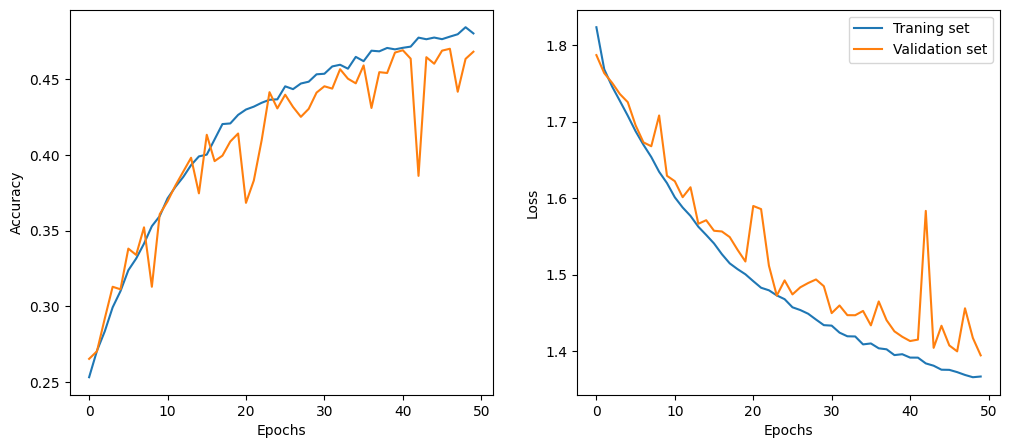

In [ ]:
# Plot loss and accuracy
fig, axs = plt.subplots(1, 2,figsize=(12,5))

x_axis=range(len(gnet_info[0]))
axs[0].plot(x_axis,gnet_info[0],label="Traning set")
axs[0].plot(x_axis,gnet_info[1],label="Validation set")
axs[0].set(ylabel="Accuracy")
axs[0].set(xlabel="Epochs")

axs[1].plot(x_axis,gnet_info[2],label="Traning set")
axs[1].plot(x_axis,gnet_info[3],label="Validation set")
axs[1].set(ylabel="Loss")
axs[1].set(xlabel="Epochs")

plt.legend()
plt.show()

Accuracy is:                  0.484
Precision of each class is:   0.38 0.0 0.27 0.56 0.54 0.38 0.58
Recall of each class is:      0.2 0.0 0.18 0.87 0.33 0.45 0.72
F1_score of each class is:    0.26 0.0 0.21 0.68 0.41 0.41 0.64



Confusion Matrix


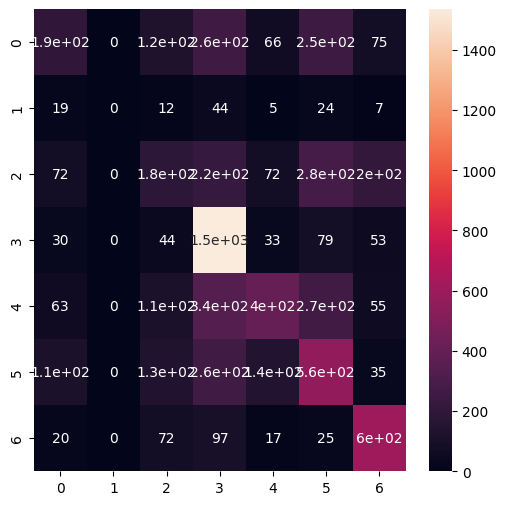

In [ ]:
test_model(gnet,criterion,test_dataloader)

In [ ]:
save_path="/content/drive/MyDrive/Project Deals/DeepLearning2023/FacialRecognition/googlenet_model.pth"
torch.save(gnet, save_path)

##4. Encoder decoder model

In [ ]:
# Define the basic building blocks: Encoder Block,Bottleneck Block, Decoder Block
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.encode = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.encode(x)
        pool = self.pool(x)
        return pool, x

class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(BottleneckBlock, self).__init__()
        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.bottleneck(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.decode = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, bridge):
        x = self.upconv(x)
        x = torch.cat((x, bridge), dim=1)
        x = self.decode(x)
        return x

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=7):
        super(UNet, self).__init__()
        # Encoder
        self.encoder1 = EncoderBlock(in_channels, 64)
        self.encoder2 = EncoderBlock(64, 128)
        self.encoder3 = EncoderBlock(128, 256)

        # Bottleneck
        self.bottleneck = BottleneckBlock(256, 512)

        # Decoder
        self.decoder3 = DecoderBlock(512, 256)
        self.decoder2 = DecoderBlock(256, 128)
        self.decoder1 = DecoderBlock(128, 64)

        # Output layer
        self.outconv = nn.Conv2d(64, 16, kernel_size=1)
        self.avgpool = nn.AvgPool2d(5, stride=2)
        self.fc = nn.Linear(7744, out_channels)

    def forward(self, x):
        # Encoder
        x, pool1 = self.encoder1(x)
        x, pool2 = self.encoder2(x)
        x, pool3 = self.encoder3(x)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder
        x = self.decoder3(x, pool3)
        x = self.decoder2(x, pool2)
        x = self.decoder1(x, pool1)

        # Output
        x = self.outconv(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.log_softmax(x, dim=-1)
        return x

In [ ]:
#Saving model diagram

save_path="/content/drive/MyDrive/Project Deals/DeepLearning2023/FacialRecognition/model_diagram/unet_model"
unet = UNet(in_channels=3, out_channels=7)
model_graph = draw_graph(unet, input_size=(1,3,48,48), expand_nested=True)
model_graph.visual_graph.render(save_path, format="png", view=True)

'/content/drive/MyDrive/Project Deals/DeepLearning2023/FacialRecognition/model_diagram/unet_model.png'

In [ ]:
# Create the U-Net model
unet = UNet(in_channels=3, out_channels=7)

# Create a U-Net model
model = unet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Train you unet model
num_epochs=50

unet,unet_info=train_model(num_epochs,model, optimizer, criterion, UNet)

  3%|▎         | 1/30 [01:27<42:31, 87.98s/it]

Epoch [1/30] : Train Loss: 1.7935, Val Loss: 1.7915,  Train Accuracy: 0.2500, Val Accuracy: 0.2558


  7%|▋         | 2/30 [02:52<40:06, 85.96s/it]

Epoch [2/30] : Train Loss: 1.7727, Val Loss: 1.7658,  Train Accuracy: 0.2613, Val Accuracy: 0.2718


 10%|█         | 3/30 [04:17<38:23, 85.31s/it]

Epoch [3/30] : Train Loss: 1.7427, Val Loss: 1.7146,  Train Accuracy: 0.2859, Val Accuracy: 0.3146


 13%|█▎        | 4/30 [05:41<36:46, 84.87s/it]

Epoch [4/30] : Train Loss: 1.6808, Val Loss: 1.6312,  Train Accuracy: 0.3281, Val Accuracy: 0.3553


 17%|█▋        | 5/30 [07:06<35:21, 84.88s/it]

Epoch [5/30] : Train Loss: 1.5793, Val Loss: 1.5611,  Train Accuracy: 0.3820, Val Accuracy: 0.3883


 20%|██        | 6/30 [08:30<33:48, 84.54s/it]

Epoch [6/30] : Train Loss: 1.5170, Val Loss: 1.5021,  Train Accuracy: 0.4050, Val Accuracy: 0.4121


 23%|██▎       | 7/30 [09:54<32:22, 84.45s/it]

Epoch [7/30] : Train Loss: 1.4751, Val Loss: 1.4655,  Train Accuracy: 0.4280, Val Accuracy: 0.4377


 27%|██▋       | 8/30 [11:18<30:53, 84.27s/it]

Epoch [8/30] : Train Loss: 1.4374, Val Loss: 1.4396,  Train Accuracy: 0.4406, Val Accuracy: 0.4395


 30%|███       | 9/30 [12:44<29:42, 84.88s/it]

Epoch [9/30] : Train Loss: 1.4112, Val Loss: 1.4269,  Train Accuracy: 0.4508, Val Accuracy: 0.4522


 33%|███▎      | 10/30 [14:10<28:24, 85.20s/it]

Epoch [10/30] : Train Loss: 1.3855, Val Loss: 1.3961,  Train Accuracy: 0.4556, Val Accuracy: 0.4627


 37%|███▋      | 11/30 [15:38<27:16, 86.12s/it]

Epoch [11/30] : Train Loss: 1.3591, Val Loss: 1.3790,  Train Accuracy: 0.4729, Val Accuracy: 0.4650


 40%|████      | 12/30 [17:10<26:22, 87.92s/it]

Epoch [12/30] : Train Loss: 1.3390, Val Loss: 1.3504,  Train Accuracy: 0.4831, Val Accuracy: 0.4812


 43%|████▎     | 13/30 [18:38<24:53, 87.85s/it]

Epoch [13/30] : Train Loss: 1.3202, Val Loss: 1.3390,  Train Accuracy: 0.4849, Val Accuracy: 0.4739


 47%|████▋     | 14/30 [20:05<23:21, 87.57s/it]

Epoch [14/30] : Train Loss: 1.3016, Val Loss: 1.3501,  Train Accuracy: 0.4917, Val Accuracy: 0.4830


 50%|█████     | 15/30 [21:32<21:53, 87.60s/it]

Epoch [15/30] : Train Loss: 1.2838, Val Loss: 1.2875,  Train Accuracy: 0.5007, Val Accuracy: 0.5095


 53%|█████▎    | 16/30 [22:58<20:16, 86.88s/it]

Epoch [16/30] : Train Loss: 1.2701, Val Loss: 1.3016,  Train Accuracy: 0.5079, Val Accuracy: 0.5039


 57%|█████▋    | 17/30 [24:22<18:40, 86.21s/it]

Epoch [17/30] : Train Loss: 1.2452, Val Loss: 1.2728,  Train Accuracy: 0.5208, Val Accuracy: 0.5104


 60%|██████    | 18/30 [25:47<17:09, 85.82s/it]

Epoch [18/30] : Train Loss: 1.2372, Val Loss: 1.2528,  Train Accuracy: 0.5244, Val Accuracy: 0.5245


 63%|██████▎   | 19/30 [27:13<15:45, 85.94s/it]

Epoch [19/30] : Train Loss: 1.2137, Val Loss: 1.2379,  Train Accuracy: 0.5323, Val Accuracy: 0.5273


 67%|██████▋   | 20/30 [28:39<14:18, 85.83s/it]

Epoch [20/30] : Train Loss: 1.1996, Val Loss: 1.2229,  Train Accuracy: 0.5361, Val Accuracy: 0.5323


 70%|███████   | 21/30 [30:05<12:52, 85.84s/it]

Epoch [21/30] : Train Loss: 1.1917, Val Loss: 1.2207,  Train Accuracy: 0.5381, Val Accuracy: 0.5327


 73%|███████▎  | 22/30 [31:32<11:28, 86.11s/it]

Epoch [22/30] : Train Loss: 1.1765, Val Loss: 1.2444,  Train Accuracy: 0.5452, Val Accuracy: 0.5283


 77%|███████▋  | 23/30 [32:58<10:04, 86.33s/it]

Epoch [23/30] : Train Loss: 1.1691, Val Loss: 1.2169,  Train Accuracy: 0.5486, Val Accuracy: 0.5365


 80%|████████  | 24/30 [34:24<08:37, 86.21s/it]

Epoch [24/30] : Train Loss: 1.1596, Val Loss: 1.2167,  Train Accuracy: 0.5547, Val Accuracy: 0.5398


 83%|████████▎ | 25/30 [35:51<07:11, 86.28s/it]

Epoch [25/30] : Train Loss: 1.1431, Val Loss: 1.1982,  Train Accuracy: 0.5616, Val Accuracy: 0.5457


 87%|████████▋ | 26/30 [37:18<05:46, 86.70s/it]

Epoch [26/30] : Train Loss: 1.1316, Val Loss: 1.2011,  Train Accuracy: 0.5653, Val Accuracy: 0.5361


 90%|█████████ | 27/30 [38:45<04:19, 86.57s/it]

Epoch [27/30] : Train Loss: 1.1245, Val Loss: 1.2156,  Train Accuracy: 0.5700, Val Accuracy: 0.5397


 93%|█████████▎| 28/30 [40:11<02:53, 86.62s/it]

Epoch [28/30] : Train Loss: 1.1193, Val Loss: 1.1666,  Train Accuracy: 0.5719, Val Accuracy: 0.5534


 97%|█████████▋| 29/30 [41:38<01:26, 86.67s/it]

Epoch [29/30] : Train Loss: 1.1156, Val Loss: 1.1562,  Train Accuracy: 0.5733, Val Accuracy: 0.5582


100%|██████████| 30/30 [43:04<00:00, 86.16s/it]

Epoch [30/30] : Train Loss: 1.1032, Val Loss: 1.1558,  Train Accuracy: 0.5742, Val Accuracy: 0.5619


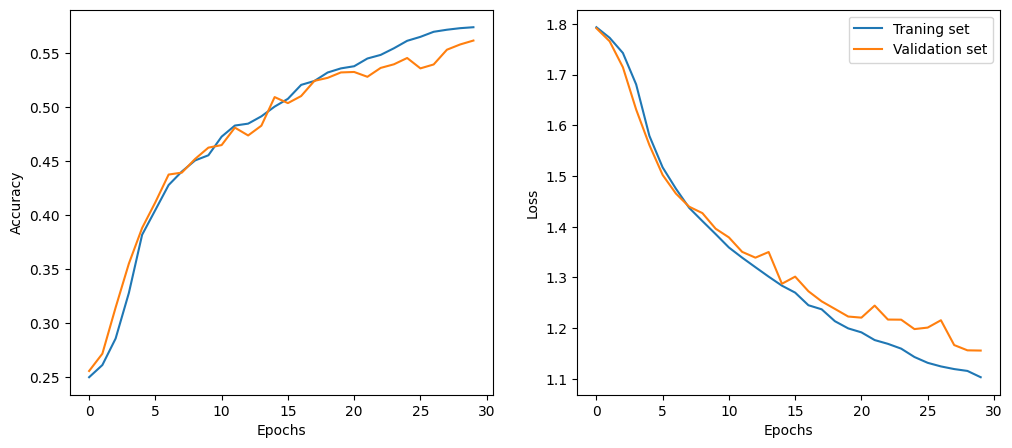

In [ ]:
# Plot loss and accuracy
fig, axs = plt.subplots(1, 2,figsize=(12,5))

x_axis=range(len(unet_info[0]))
axs[0].plot(x_axis,unet_info[0],label="Traning set")
axs[0].plot(x_axis,unet_info[1],label="Validation set")
axs[0].set(ylabel="Accuracy")
axs[0].set(xlabel="Epochs")

axs[1].plot(x_axis,unet_info[2],label="Traning set")
axs[1].plot(x_axis,unet_info[3],label="Validation set")
axs[1].set(ylabel="Loss")
axs[1].set(xlabel="Epochs")

plt.legend()
plt.show()

Accuracy is:                  0.607
Precision of each class is:   0.56 0.45 0.44 0.81 0.52 0.46 0.69
Recall of each class is:      0.47 0.23 0.28 0.9 0.61 0.49 0.77
F1_score of each class is:    0.51 0.31 0.34 0.85 0.56 0.48 0.73



Confusion Matrix


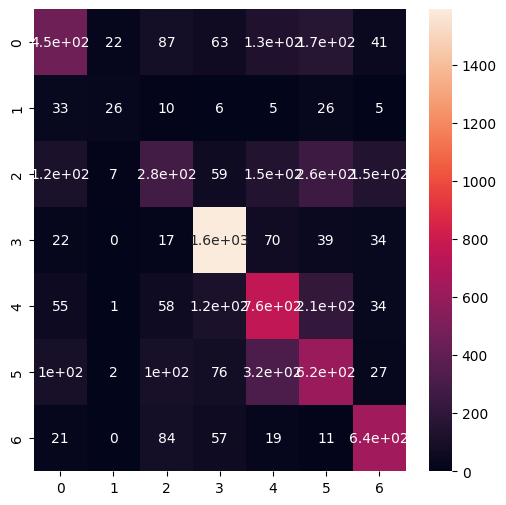

In [ ]:
test_model(unet,criterion,test_dataloader)

In [ ]:
save_path="/content/drive/MyDrive/Project Deals/DeepLearning2023/FacialRecognition/encoder_decoder_model.pth"
torch.save(unet, save_path)

##5. Newnet model

In [ ]:
class NewNet(nn.Module):
    def __init__(self, num_classes=7):
        super(NewNet, self).__init__()
        self.conv1 = BasicConv2d(16, 64, kernel_size=3, stride=1, padding=1)
        self.maxpool1 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        self.enc_dc=UNet(in_channels=3, out_channels=7)

        self.inception1 = InceptionModule(64, 16, 32, 16, 32, 16, 32, 16)
        self.inception2 = InceptionModule(48, 16, 32, 16, 32, 16, 32, 16)

        self.maxpool2 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.1)
        self.conv2 = BasicConv2d(48, 32, kernel_size=3, stride=1, padding=1)

        self.avgpool = nn.AvgPool2d(5, stride=2)
        self.conv3 = BasicConv2d(48, 16, kernel_size=3, stride=2, padding=1)
        self.fc = nn.Linear(1936, num_classes)

    def forward(self, x):
        enc_x = self.enc_dc(x)
        # x1 = self.conv1(enc_x)
        x = self.conv1(enc_x)
        # x = torch.cat([x1,x2], 1)
        x = self.inception1(x)
        x = self.dropout1(x)
        x = self.inception2(x)
        # x = self.maxpool2(x)
        x = self.dropout2(x)
        # x = F.adaptive_avg_pool2d(x, (1, 1))
        x = self.avgpool(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.log_softmax(x, dim=-1)
        return x

In [ ]:
#Saving model diagram

save_path="/content/drive/MyDrive/Project Deals/DeepLearning2023/FacialRecognition/model_diagram/new_net_model"
model_graph = draw_graph(NewNet(), input_size=(1,3,48,48), expand_nested=True)
model_graph.visual_graph.render(save_path, format="png", view=True)

'/content/drive/MyDrive/Project Deals/DeepLearning2023/FacialRecognition/model_diagram/new_net_model.png'

In [ ]:
# Create a NewNet model
nnet = NewNet()

# Train your NewNet Model
model = nnet.to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
num_epochs=50

nnet,nnet_info=train_model(num_epochs,model,optimizer,criterion,NewNet)

  2%|▏         | 1/50 [01:41<1:22:56, 101.56s/it]

Epoch [1/50] : Train Loss: 1.7932, Val Loss: 1.7649,  Train Accuracy: 0.2543, Val Accuracy: 0.2705


  4%|▍         | 2/50 [03:24<1:21:40, 102.09s/it]

Epoch [2/50] : Train Loss: 1.7560, Val Loss: 1.7368,  Train Accuracy: 0.2847, Val Accuracy: 0.2909


  6%|▌         | 3/50 [05:05<1:19:36, 101.63s/it]

Epoch [3/50] : Train Loss: 1.7075, Val Loss: 1.6691,  Train Accuracy: 0.3105, Val Accuracy: 0.3318


  8%|▊         | 4/50 [06:46<1:17:53, 101.60s/it]

Epoch [4/50] : Train Loss: 1.6382, Val Loss: 1.6166,  Train Accuracy: 0.3455, Val Accuracy: 0.3530


 10%|█         | 5/50 [08:30<1:16:41, 102.25s/it]

Epoch [5/50] : Train Loss: 1.5698, Val Loss: 1.5656,  Train Accuracy: 0.3815, Val Accuracy: 0.3824


 12%|█▏        | 6/50 [10:12<1:14:54, 102.15s/it]

Epoch [6/50] : Train Loss: 1.5223, Val Loss: 1.5393,  Train Accuracy: 0.4065, Val Accuracy: 0.4018


 14%|█▍        | 7/50 [11:54<1:13:24, 102.42s/it]

Epoch [7/50] : Train Loss: 1.4812, Val Loss: 1.5257,  Train Accuracy: 0.4227, Val Accuracy: 0.4171


 16%|█▌        | 8/50 [13:37<1:11:40, 102.39s/it]

Epoch [8/50] : Train Loss: 1.4486, Val Loss: 1.5005,  Train Accuracy: 0.4363, Val Accuracy: 0.4256


 18%|█▊        | 9/50 [15:20<1:10:06, 102.60s/it]

Epoch [9/50] : Train Loss: 1.4205, Val Loss: 1.4328,  Train Accuracy: 0.4518, Val Accuracy: 0.4452


 20%|██        | 10/50 [17:07<1:09:22, 104.06s/it]

Epoch [10/50] : Train Loss: 1.3962, Val Loss: 1.4589,  Train Accuracy: 0.4655, Val Accuracy: 0.4444


 22%|██▏       | 11/50 [18:49<1:07:11, 103.38s/it]

Epoch [11/50] : Train Loss: 1.3767, Val Loss: 1.3974,  Train Accuracy: 0.4702, Val Accuracy: 0.4716


 24%|██▍       | 12/50 [20:31<1:05:06, 102.80s/it]

Epoch [12/50] : Train Loss: 1.3619, Val Loss: 1.3599,  Train Accuracy: 0.4770, Val Accuracy: 0.4742


 26%|██▌       | 13/50 [22:12<1:03:10, 102.45s/it]

Epoch [13/50] : Train Loss: 1.3419, Val Loss: 1.3665,  Train Accuracy: 0.4876, Val Accuracy: 0.4733


 28%|██▊       | 14/50 [23:53<1:01:13, 102.04s/it]

Epoch [14/50] : Train Loss: 1.3248, Val Loss: 1.3629,  Train Accuracy: 0.4907, Val Accuracy: 0.4822


 30%|███       | 15/50 [25:34<59:22, 101.78s/it]  

Epoch [15/50] : Train Loss: 1.3174, Val Loss: 1.3341,  Train Accuracy: 0.4980, Val Accuracy: 0.4944


 32%|███▏      | 16/50 [27:16<57:39, 101.75s/it]

Epoch [16/50] : Train Loss: 1.3000, Val Loss: 1.3539,  Train Accuracy: 0.5096, Val Accuracy: 0.4897


 34%|███▍      | 17/50 [28:57<55:51, 101.56s/it]

Epoch [17/50] : Train Loss: 1.2919, Val Loss: 1.4023,  Train Accuracy: 0.5060, Val Accuracy: 0.4767


 36%|███▌      | 18/50 [30:39<54:11, 101.61s/it]

Epoch [18/50] : Train Loss: 1.2820, Val Loss: 1.2998,  Train Accuracy: 0.5127, Val Accuracy: 0.5085


 38%|███▊      | 19/50 [32:20<52:21, 101.35s/it]

Epoch [19/50] : Train Loss: 1.2695, Val Loss: 1.3095,  Train Accuracy: 0.5138, Val Accuracy: 0.5067


 40%|████      | 20/50 [34:01<50:38, 101.29s/it]

Epoch [20/50] : Train Loss: 1.2584, Val Loss: 1.2742,  Train Accuracy: 0.5177, Val Accuracy: 0.5177


 42%|████▏     | 21/50 [35:42<48:57, 101.29s/it]

Epoch [21/50] : Train Loss: 1.2507, Val Loss: 1.2984,  Train Accuracy: 0.5252, Val Accuracy: 0.5074


 44%|████▍     | 22/50 [37:23<47:12, 101.16s/it]

Epoch [22/50] : Train Loss: 1.2416, Val Loss: 1.4099,  Train Accuracy: 0.5278, Val Accuracy: 0.4710


 46%|████▌     | 23/50 [39:04<45:32, 101.19s/it]

Epoch [23/50] : Train Loss: 1.2459, Val Loss: 1.3213,  Train Accuracy: 0.5304, Val Accuracy: 0.4987


 48%|████▊     | 24/50 [40:46<43:52, 101.24s/it]

Epoch [24/50] : Train Loss: 1.2273, Val Loss: 1.2672,  Train Accuracy: 0.5351, Val Accuracy: 0.5195


 50%|█████     | 25/50 [42:27<42:08, 101.15s/it]

Epoch [25/50] : Train Loss: 1.2244, Val Loss: 1.2753,  Train Accuracy: 0.5350, Val Accuracy: 0.5143


 52%|█████▏    | 26/50 [44:14<41:10, 102.92s/it]

Epoch [26/50] : Train Loss: 1.2250, Val Loss: 1.2395,  Train Accuracy: 0.5328, Val Accuracy: 0.5389


 54%|█████▍    | 27/50 [45:56<39:20, 102.62s/it]

Epoch [27/50] : Train Loss: 1.2100, Val Loss: 1.2743,  Train Accuracy: 0.5397, Val Accuracy: 0.5180


 56%|█████▌    | 28/50 [47:38<37:37, 102.62s/it]

Epoch [28/50] : Train Loss: 1.2074, Val Loss: 1.2248,  Train Accuracy: 0.5439, Val Accuracy: 0.5411


 58%|█████▊    | 29/50 [49:19<35:43, 102.09s/it]

Epoch [29/50] : Train Loss: 1.1957, Val Loss: 1.2387,  Train Accuracy: 0.5436, Val Accuracy: 0.5294


 60%|██████    | 30/50 [51:01<34:00, 102.03s/it]

Epoch [30/50] : Train Loss: 1.1993, Val Loss: 1.2471,  Train Accuracy: 0.5485, Val Accuracy: 0.5267


 62%|██████▏   | 31/50 [52:42<32:12, 101.70s/it]

Epoch [31/50] : Train Loss: 1.1950, Val Loss: 1.2248,  Train Accuracy: 0.5471, Val Accuracy: 0.5333


 64%|██████▍   | 32/50 [54:23<30:28, 101.61s/it]

Epoch [32/50] : Train Loss: 1.1868, Val Loss: 1.2365,  Train Accuracy: 0.5461, Val Accuracy: 0.5415


 66%|██████▌   | 33/50 [56:04<28:44, 101.46s/it]

Epoch [33/50] : Train Loss: 1.1872, Val Loss: 1.2304,  Train Accuracy: 0.5472, Val Accuracy: 0.5375


 68%|██████▊   | 34/50 [57:46<27:02, 101.40s/it]

Epoch [34/50] : Train Loss: 1.1827, Val Loss: 1.2128,  Train Accuracy: 0.5546, Val Accuracy: 0.5483


 70%|███████   | 35/50 [59:28<25:25, 101.71s/it]

Epoch [35/50] : Train Loss: 1.1779, Val Loss: 1.2043,  Train Accuracy: 0.5568, Val Accuracy: 0.5365


 72%|███████▏  | 36/50 [1:01:10<23:44, 101.76s/it]

Epoch [36/50] : Train Loss: 1.1797, Val Loss: 1.2111,  Train Accuracy: 0.5550, Val Accuracy: 0.5458


 74%|███████▍  | 37/50 [1:02:52<22:05, 101.96s/it]

Epoch [37/50] : Train Loss: 1.1730, Val Loss: 1.1741,  Train Accuracy: 0.5577, Val Accuracy: 0.5542


 76%|███████▌  | 38/50 [1:04:35<20:26, 102.19s/it]

Epoch [38/50] : Train Loss: 1.1663, Val Loss: 1.2805,  Train Accuracy: 0.5609, Val Accuracy: 0.5244


 78%|███████▊  | 39/50 [1:06:18<18:46, 102.42s/it]

Epoch [39/50] : Train Loss: 1.1645, Val Loss: 1.2041,  Train Accuracy: 0.5566, Val Accuracy: 0.5502


 80%|████████  | 40/50 [1:08:01<17:05, 102.58s/it]

Epoch [40/50] : Train Loss: 1.1620, Val Loss: 1.2040,  Train Accuracy: 0.5615, Val Accuracy: 0.5468


 82%|████████▏ | 41/50 [1:09:44<15:23, 102.62s/it]

Epoch [41/50] : Train Loss: 1.1620, Val Loss: 1.2011,  Train Accuracy: 0.5611, Val Accuracy: 0.5475


 84%|████████▍ | 42/50 [1:11:26<13:40, 102.57s/it]

Epoch [42/50] : Train Loss: 1.1575, Val Loss: 1.2123,  Train Accuracy: 0.5618, Val Accuracy: 0.5428


 86%|████████▌ | 43/50 [1:13:08<11:55, 102.26s/it]

Epoch [43/50] : Train Loss: 1.1435, Val Loss: 1.2133,  Train Accuracy: 0.5665, Val Accuracy: 0.5458


 88%|████████▊ | 44/50 [1:14:50<10:13, 102.25s/it]

Epoch [44/50] : Train Loss: 1.1479, Val Loss: 1.2251,  Train Accuracy: 0.5655, Val Accuracy: 0.5403


 90%|█████████ | 45/50 [1:16:31<08:29, 101.99s/it]

Epoch [45/50] : Train Loss: 1.1424, Val Loss: 1.2179,  Train Accuracy: 0.5689, Val Accuracy: 0.5313


 92%|█████████▏| 46/50 [1:18:19<06:55, 103.80s/it]

Epoch [46/50] : Train Loss: 1.1433, Val Loss: 1.1710,  Train Accuracy: 0.5663, Val Accuracy: 0.5520


 94%|█████████▍| 47/50 [1:20:00<05:08, 102.99s/it]

Epoch [47/50] : Train Loss: 1.1389, Val Loss: 1.1799,  Train Accuracy: 0.5717, Val Accuracy: 0.5514


 96%|█████████▌| 48/50 [1:21:42<03:25, 102.70s/it]

Epoch [48/50] : Train Loss: 1.1398, Val Loss: 1.1865,  Train Accuracy: 0.5676, Val Accuracy: 0.5542


 98%|█████████▊| 49/50 [1:23:24<01:42, 102.36s/it]

Epoch [49/50] : Train Loss: 1.1387, Val Loss: 1.1943,  Train Accuracy: 0.5742, Val Accuracy: 0.5496


100%|██████████| 50/50 [1:25:06<00:00, 102.13s/it]

Epoch [50/50] : Train Loss: 1.1288, Val Loss: 1.1678,  Train Accuracy: 0.5720, Val Accuracy: 0.5658


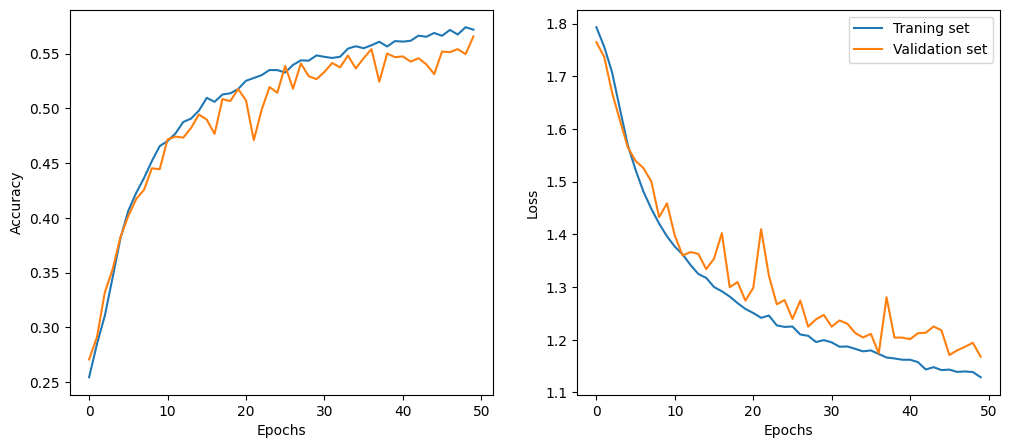

In [ ]:
# Plot loss and accuracy
fig, axs = plt.subplots(1, 2,figsize=(12,5))

x_axis=range(len(nnet_info[0]))
axs[0].plot(x_axis,nnet_info[0],label="Traning set")
axs[0].plot(x_axis,nnet_info[1],label="Validation set")
axs[0].set(ylabel="Accuracy")
axs[0].set(xlabel="Epochs")

axs[1].plot(x_axis,nnet_info[2],label="Traning set")
axs[1].plot(x_axis,nnet_info[3],label="Validation set")
axs[1].set(ylabel="Loss")
axs[1].set(xlabel="Epochs")

plt.legend()
plt.show()

Accuracy is:                  0.606
Precision of each class is:   0.53 0.48 0.42 0.78 0.58 0.45 0.76
Recall of each class is:      0.53 0.31 0.35 0.88 0.56 0.48 0.72
F1_score of each class is:    0.53 0.37 0.38 0.83 0.57 0.47 0.74



Confusion Matrix


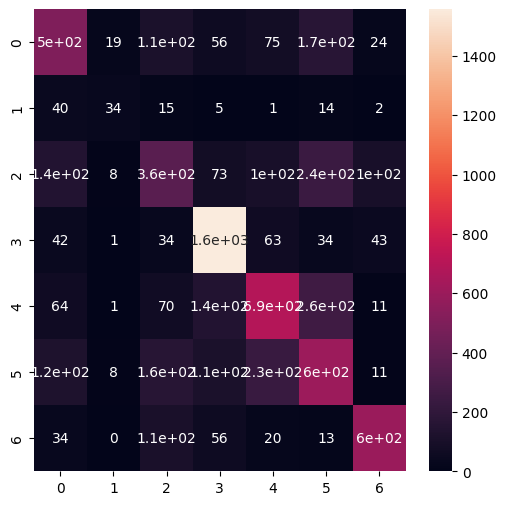

In [ ]:
test_model(nnet,criterion,test_dataloader)

In [ ]:
save_path="/content/drive/MyDrive/Project Deals/DeepLearning2023/FacialRecognition/new_net_model.pth"
torch.save(nnet, save_path)

##6. Custom model(rogle_net) using renet and google net

In [53]:
class RogleNet(nn.Module):
    def __init__(self, num_classes=7):
        super(RogleNet, self).__init__()

        # Define convolutional layers for different pathways
        self.pathway1_conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True)
        )

        self.pathway2_conv1x1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=1, stride=1),
            nn.ReLU(inplace=True)
        )
        self.pathway2_conv3x3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True)
        )

        self.pathway3_conv1x1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=1, stride=1),
            nn.ReLU(inplace=True)
        )
        self.pathway3_conv5x5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True)
        )

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Define residual layers
        self.residual_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        )
        self.residual_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        )

        self.final_cnn = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1)
        )
        # Fully connected layers for classification
        self.fc = nn.Sequential(
            nn.Linear(147456, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes))

    def forward(self, x):
        # Pathway 1
        pathway1_out = self.pathway1_conv(x)

        # Pathway 2
        pathway2_conv1x1 = self.pathway2_conv1x1(x)
        pathway2_out = self.pathway2_conv3x3(pathway2_conv1x1)

        # Pathway 3
        pathway3_conv1x1 = self.pathway3_conv1x1(x)
        pathway3_out = self.pathway3_conv5x5(pathway3_conv1x1)

        # Concatenate pathway outputs
        concatenated = torch.cat((pathway1_out, pathway2_out, pathway3_out), dim=1)

        # Max pooling
        maxpool_out = self.maxpool(concatenated)

        # Residual connections
        residual_out = self.residual_conv1(maxpool_out)
        residual_out = maxpool_out + self.residual_conv2(residual_out)

        fcnn_out = self.final_cnn(residual_out)
        # Flatten before fully connected layers
        out = residual_out.view(fcnn_out.size(0), -1)
        out = self.fc(out)

        return out

In [59]:
class CustomLoss(nn.Module):
    def __init__(self, class_weights):
        super(CustomLoss, self).__init__()
        self.weights = torch.Tensor(class_weights).to(device)

    def forward(self, outputs, targets):
        loss = nn.CrossEntropyLoss(weight=self.weights)(outputs, targets)
        return loss

In [55]:
#Saving model diagram

save_path="/content/drive/MyDrive/Project Deals/DeepLearning2023/FacialRecognition/model_diagram/rogle_net"
model_graph = draw_graph(RogleNet(), input_size=(1,3,48,48), expand_nested=True)
model_graph.visual_graph.render(save_path, format="png", view=True)

'/content/drive/MyDrive/Project Deals/DeepLearning2023/FacialRecognition/model_diagram/rogle_net.png'

In [60]:
# Create a NewNet model
rogle_net = RogleNet()

# Train your NewNet Model
model = rogle_net.to(device)

weights = [1,1.2,1.2,1.2,1.2,1.2,2]
criterion = CustomLoss(weights)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
num_epochs=50

rogle_net,rogle_net_info=train_model(num_epochs,model,optimizer,criterion,RogleNet)

  2%|▏         | 1/50 [01:19<1:05:00, 79.59s/it]

Epoch [1/50] : Train Loss: 1.7856, Val Loss: 1.7585,  Train Accuracy: 0.2450, Val Accuracy: 0.2618


  4%|▍         | 2/50 [02:37<1:03:00, 78.77s/it]

Epoch [2/50] : Train Loss: 1.7506, Val Loss: 1.7340,  Train Accuracy: 0.2680, Val Accuracy: 0.2813


  6%|▌         | 3/50 [03:56<1:01:36, 78.64s/it]

Epoch [3/50] : Train Loss: 1.7297, Val Loss: 1.7178,  Train Accuracy: 0.2866, Val Accuracy: 0.3026


  8%|▊         | 4/50 [05:14<1:00:04, 78.37s/it]

Epoch [4/50] : Train Loss: 1.7024, Val Loss: 1.6794,  Train Accuracy: 0.3046, Val Accuracy: 0.3275


 10%|█         | 5/50 [06:32<58:41, 78.26s/it]  

Epoch [5/50] : Train Loss: 1.6696, Val Loss: 1.6573,  Train Accuracy: 0.3237, Val Accuracy: 0.3094


 12%|█▏        | 6/50 [07:50<57:20, 78.19s/it]

Epoch [6/50] : Train Loss: 1.6300, Val Loss: 1.6174,  Train Accuracy: 0.3433, Val Accuracy: 0.3544


 14%|█▍        | 7/50 [09:08<56:05, 78.28s/it]

Epoch [7/50] : Train Loss: 1.5901, Val Loss: 1.5712,  Train Accuracy: 0.3628, Val Accuracy: 0.3677


 16%|█▌        | 8/50 [10:27<54:47, 78.29s/it]

Epoch [8/50] : Train Loss: 1.5578, Val Loss: 1.5250,  Train Accuracy: 0.3775, Val Accuracy: 0.4025


 18%|█▊        | 9/50 [11:45<53:30, 78.30s/it]

Epoch [9/50] : Train Loss: 1.5306, Val Loss: 1.5158,  Train Accuracy: 0.3846, Val Accuracy: 0.4032


 20%|██        | 10/50 [13:04<52:15, 78.39s/it]

Epoch [10/50] : Train Loss: 1.5009, Val Loss: 1.4721,  Train Accuracy: 0.4052, Val Accuracy: 0.4068


 22%|██▏       | 11/50 [14:22<50:58, 78.43s/it]

Epoch [11/50] : Train Loss: 1.4679, Val Loss: 1.4493,  Train Accuracy: 0.4198, Val Accuracy: 0.4164


 24%|██▍       | 12/50 [15:40<49:39, 78.40s/it]

Epoch [12/50] : Train Loss: 1.4407, Val Loss: 1.4461,  Train Accuracy: 0.4324, Val Accuracy: 0.4384


 26%|██▌       | 13/50 [16:59<48:18, 78.33s/it]

Epoch [13/50] : Train Loss: 1.4157, Val Loss: 1.4533,  Train Accuracy: 0.4391, Val Accuracy: 0.4331


 28%|██▊       | 14/50 [18:17<47:00, 78.35s/it]

Epoch [14/50] : Train Loss: 1.3945, Val Loss: 1.3871,  Train Accuracy: 0.4460, Val Accuracy: 0.4437


 30%|███       | 15/50 [19:35<45:41, 78.33s/it]

Epoch [15/50] : Train Loss: 1.3634, Val Loss: 1.3449,  Train Accuracy: 0.4631, Val Accuracy: 0.4649


 32%|███▏      | 16/50 [20:54<44:23, 78.35s/it]

Epoch [16/50] : Train Loss: 1.3442, Val Loss: 1.3316,  Train Accuracy: 0.4717, Val Accuracy: 0.4755


 34%|███▍      | 17/50 [22:12<43:00, 78.21s/it]

Epoch [17/50] : Train Loss: 1.3160, Val Loss: 1.2894,  Train Accuracy: 0.4856, Val Accuracy: 0.4844


 36%|███▌      | 18/50 [23:29<41:38, 78.09s/it]

Epoch [18/50] : Train Loss: 1.3059, Val Loss: 1.2882,  Train Accuracy: 0.4870, Val Accuracy: 0.4954


 38%|███▊      | 19/50 [24:47<40:20, 78.09s/it]

Epoch [19/50] : Train Loss: 1.2879, Val Loss: 1.2766,  Train Accuracy: 0.4918, Val Accuracy: 0.4987


 40%|████      | 20/50 [26:06<39:03, 78.11s/it]

Epoch [20/50] : Train Loss: 1.2638, Val Loss: 1.2705,  Train Accuracy: 0.5027, Val Accuracy: 0.4932


 42%|████▏     | 21/50 [27:24<37:47, 78.18s/it]

Epoch [21/50] : Train Loss: 1.2440, Val Loss: 1.2649,  Train Accuracy: 0.5092, Val Accuracy: 0.4994


 44%|████▍     | 22/50 [28:42<36:32, 78.29s/it]

Epoch [22/50] : Train Loss: 1.2341, Val Loss: 1.2329,  Train Accuracy: 0.5165, Val Accuracy: 0.5092


 46%|████▌     | 23/50 [30:01<35:14, 78.32s/it]

Epoch [23/50] : Train Loss: 1.2173, Val Loss: 1.2219,  Train Accuracy: 0.5241, Val Accuracy: 0.5137


 48%|████▊     | 24/50 [31:19<33:57, 78.38s/it]

Epoch [24/50] : Train Loss: 1.2029, Val Loss: 1.2152,  Train Accuracy: 0.5272, Val Accuracy: 0.5185


 50%|█████     | 25/50 [32:37<32:37, 78.28s/it]

Epoch [25/50] : Train Loss: 1.1897, Val Loss: 1.2044,  Train Accuracy: 0.5338, Val Accuracy: 0.5284


 52%|█████▏    | 26/50 [33:55<31:13, 78.06s/it]

Epoch [26/50] : Train Loss: 1.1786, Val Loss: 1.1761,  Train Accuracy: 0.5372, Val Accuracy: 0.5265


 54%|█████▍    | 27/50 [35:13<29:52, 77.92s/it]

Epoch [27/50] : Train Loss: 1.1640, Val Loss: 1.2224,  Train Accuracy: 0.5415, Val Accuracy: 0.5177


 56%|█████▌    | 28/50 [36:30<28:32, 77.82s/it]

Epoch [28/50] : Train Loss: 1.1628, Val Loss: 1.1797,  Train Accuracy: 0.5471, Val Accuracy: 0.5267


 58%|█████▊    | 29/50 [37:47<27:11, 77.67s/it]

Epoch [29/50] : Train Loss: 1.1415, Val Loss: 1.1716,  Train Accuracy: 0.5532, Val Accuracy: 0.5389


 60%|██████    | 30/50 [39:05<25:51, 77.57s/it]

Epoch [30/50] : Train Loss: 1.1382, Val Loss: 1.1663,  Train Accuracy: 0.5547, Val Accuracy: 0.5359


 62%|██████▏   | 31/50 [40:22<24:30, 77.39s/it]

Epoch [31/50] : Train Loss: 1.1268, Val Loss: 1.1456,  Train Accuracy: 0.5585, Val Accuracy: 0.5492


 64%|██████▍   | 32/50 [41:39<23:11, 77.31s/it]

Epoch [32/50] : Train Loss: 1.1166, Val Loss: 1.1604,  Train Accuracy: 0.5617, Val Accuracy: 0.5508


 66%|██████▌   | 33/50 [42:57<21:56, 77.41s/it]

Epoch [33/50] : Train Loss: 1.1113, Val Loss: 1.1403,  Train Accuracy: 0.5653, Val Accuracy: 0.5479


 68%|██████▊   | 34/50 [44:14<20:36, 77.31s/it]

Epoch [34/50] : Train Loss: 1.1001, Val Loss: 1.1296,  Train Accuracy: 0.5721, Val Accuracy: 0.5543


 70%|███████   | 35/50 [45:31<19:18, 77.26s/it]

Epoch [35/50] : Train Loss: 1.0868, Val Loss: 1.1279,  Train Accuracy: 0.5744, Val Accuracy: 0.5584


 72%|███████▏  | 36/50 [46:48<18:02, 77.33s/it]

Epoch [36/50] : Train Loss: 1.0816, Val Loss: 1.1320,  Train Accuracy: 0.5776, Val Accuracy: 0.5525


 74%|███████▍  | 37/50 [48:05<16:43, 77.17s/it]

Epoch [37/50] : Train Loss: 1.0714, Val Loss: 1.1105,  Train Accuracy: 0.5831, Val Accuracy: 0.5574


 76%|███████▌  | 38/50 [49:22<15:25, 77.12s/it]

Epoch [38/50] : Train Loss: 1.0667, Val Loss: 1.1142,  Train Accuracy: 0.5873, Val Accuracy: 0.5663


 78%|███████▊  | 39/50 [50:39<14:07, 77.08s/it]

Epoch [39/50] : Train Loss: 1.0568, Val Loss: 1.1300,  Train Accuracy: 0.5907, Val Accuracy: 0.5648


 80%|████████  | 40/50 [51:56<12:49, 76.93s/it]

Epoch [40/50] : Train Loss: 1.0510, Val Loss: 1.1148,  Train Accuracy: 0.5899, Val Accuracy: 0.5567


 82%|████████▏ | 41/50 [53:12<11:29, 76.65s/it]

Epoch [41/50] : Train Loss: 1.0414, Val Loss: 1.1026,  Train Accuracy: 0.5938, Val Accuracy: 0.5659


 84%|████████▍ | 42/50 [54:28<10:12, 76.51s/it]

Epoch [42/50] : Train Loss: 1.0345, Val Loss: 1.1032,  Train Accuracy: 0.5954, Val Accuracy: 0.5697


 86%|████████▌ | 43/50 [55:44<08:55, 76.48s/it]

Epoch [43/50] : Train Loss: 1.0239, Val Loss: 1.1094,  Train Accuracy: 0.6007, Val Accuracy: 0.5575


 88%|████████▊ | 44/50 [57:00<07:37, 76.31s/it]

Epoch [44/50] : Train Loss: 1.0205, Val Loss: 1.0990,  Train Accuracy: 0.6028, Val Accuracy: 0.5717


 90%|█████████ | 45/50 [58:16<06:21, 76.22s/it]

Epoch [45/50] : Train Loss: 1.0192, Val Loss: 1.0873,  Train Accuracy: 0.5971, Val Accuracy: 0.5740


 92%|█████████▏| 46/50 [59:32<05:04, 76.13s/it]

Epoch [46/50] : Train Loss: 1.0096, Val Loss: 1.0994,  Train Accuracy: 0.6074, Val Accuracy: 0.5755


 94%|█████████▍| 47/50 [1:00:48<03:48, 76.18s/it]

Epoch [47/50] : Train Loss: 1.0015, Val Loss: 1.0862,  Train Accuracy: 0.6076, Val Accuracy: 0.5761


 96%|█████████▌| 48/50 [1:02:04<02:32, 76.05s/it]

Epoch [48/50] : Train Loss: 1.0015, Val Loss: 1.1111,  Train Accuracy: 0.6113, Val Accuracy: 0.5663


 98%|█████████▊| 49/50 [1:03:20<01:15, 75.98s/it]

Epoch [49/50] : Train Loss: 0.9894, Val Loss: 1.0730,  Train Accuracy: 0.6147, Val Accuracy: 0.5848


100%|██████████| 50/50 [1:04:36<00:00, 77.52s/it]

Epoch [50/50] : Train Loss: 0.9773, Val Loss: 1.0756,  Train Accuracy: 0.6154, Val Accuracy: 0.5770


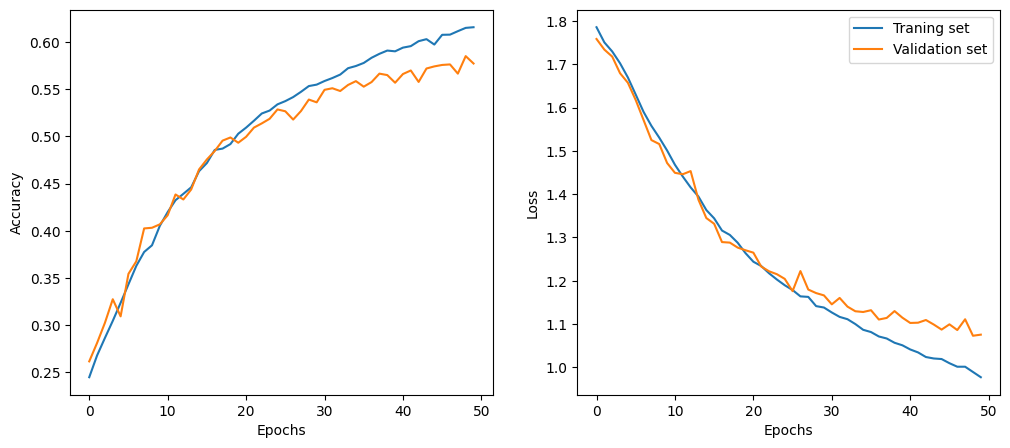

In [61]:
# Plot loss and accuracy
fig, axs = plt.subplots(1, 2,figsize=(12,5))

x_axis=range(len(rogle_net_info[0]))
axs[0].plot(x_axis,rogle_net_info[0],label="Traning set")
axs[0].plot(x_axis,rogle_net_info[1],label="Validation set")
axs[0].set(ylabel="Accuracy")
axs[0].set(xlabel="Epochs")

axs[1].plot(x_axis,rogle_net_info[2],label="Traning set")
axs[1].plot(x_axis,rogle_net_info[3],label="Validation set")
axs[1].set(ylabel="Loss")
axs[1].set(xlabel="Epochs")

plt.legend()
plt.show()

Accuracy is:                  0.606
Precision of each class is:   0.54 0.61 0.45 0.83 0.51 0.52 0.63
Recall of each class is:      0.48 0.28 0.37 0.84 0.65 0.4 0.84
F1_score of each class is:    0.51 0.38 0.4 0.84 0.57 0.45 0.72



Confusion Matrix


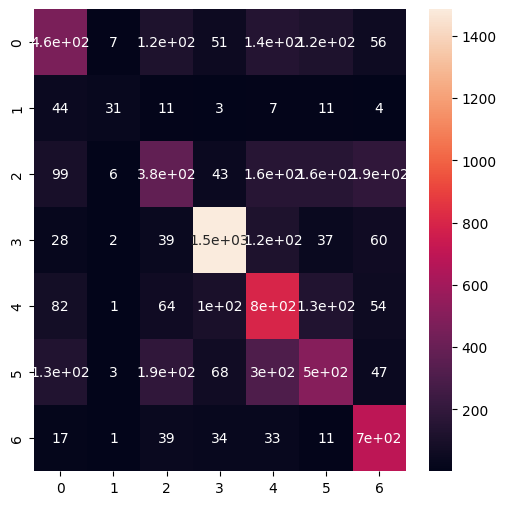

In [63]:
test_model(rogle_net,criterion,test_dataloader)

In [64]:
save_path="/content/drive/MyDrive/Project Deals/DeepLearning2023/FacialRecognition/rogle_net_model.pth"
torch.save(rogle_net_info, save_path)